In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [ ]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [ ]:
train_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))

train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5

In [ ]:
def make_generator_model(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(16*16*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 64))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [7]:
generator = make_generator_model((100,))
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             1654784   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 32)        1843

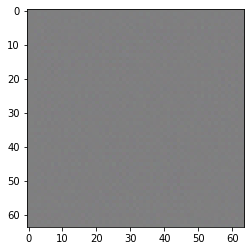

In [8]:
generator = make_generator_model((100,))

noise = np.random.normal(0, 1, 100)

generated_image = generator.predict(np.array([noise]))[0]
plt.imshow(unnormalize_img(generated_image), )

In [9]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    
    return Model(input_layer, x)

In [10]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator.predict(np.array([generated_image]))
print (decision)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0   

In [11]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * tf.constant(0.9), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [68]:
@tf.function
def train_step(images):
    noise = tf.random.truncated_normal([32, 100])
    
    gen_losses = []
    disc_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))

#     do_train = sum(disc_losses)/len(disc_losses) > 0.
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
#     if do_train:
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        
    return (gen_losses, disc_losses)

In [69]:
def train(train_imgs, epochs):
    gen_loss_all = []
    disc_loss_all = []
    
    num_imgs = len(train_imgs)
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        
        np.random.shuffle(train_imgs)
        
        for i in range(0, num_imgs - 32, 32):
            gen_loss_batch, disc_loss_batch = train_step(train_imgs[i:(i+32)])

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
    
    return (gen_loss_all, disc_loss_all)
    


In [43]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, d_hist=None, noise=None):
    
    if noise is None:
        noise = np.random.normal(0, 1, 100)

    if g_hist is None:
        g_hist = []
    
    if d_hist is None:
        d_hist = []

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, disc_temp = train(train_imgs, checkpoint_interval)
        g_hist += gen_temp
        d_hist += disc_temp
        generated_image = generator.predict(np.array([noise]))[0]
        plt.imshow(unnormalize_img(generated_image))
        plt.savefig('./results/prog-imgs/bird-gan-deeper-smaller-z/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        generator.save_weights('./results/weights/bird-gan-deeper-smaller-z/gen_weights_deeper_smaller_z_' + str((i+1)*checkpoint_interval) + '.h5')
        discriminator.save_weights('./results/weights/bird-gan-deeper-smaller-z/disc_weights_deeper_smaller_z_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints

In [66]:
discriminator = make_discriminator_model()
generator = make_generator_model((100,))
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [67]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
disc_loss_hist = []
noise = np.random.normal(0, 1, 100)
next_starting_checkpoint = 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 14.96377444267273 sec
Gen loss: 6.150409752437416, Disc loss: 0.3833842262989137
Time for epoch 2 is 13.053259372711182 sec
Gen loss: 7.966061899655557, Disc loss: 0.34128593130486445
Time for epoch 3 is 14.020951271057129 sec
Gen loss: 8.3208302424206, Disc loss: 0.34701094693607754
Time for epoch 4 is 13.930000305175781 sec
Gen loss: 8.129714360405114, Disc loss: 0.35

Time for epoch 73 is 13.175214290618896 sec
Gen loss: 5.081384604539329, Disc loss: 0.4381093374758878
Time for epoch 74 is 13.064667224884033 sec
Gen loss: 4.924485397209643, Disc loss: 0.46228672963816947
Time for epoch 75 is 13.094961166381836 sec
Gen loss: 4.721264653735691, Disc loss: 0.46963082112594023
Time for epoch 76 is 13.070872783660889 sec
Gen loss: 4.868448310428196, Disc loss: 0.4479301968402656
Time for epoch 77 is 13.058189630508423 sec
Gen loss: 4.882259060696858, Disc loss: 0.441633758021564
Time for epoch 78 is 13.14621901512146 sec
Gen loss: 4.868663756181877, Disc loss: 0.4569109511084673
Time for epoch 79 is 13.104148387908936 sec
Gen loss: 5.229770073722695, Disc loss: 0.4400156839753231
Time for epoch 80 is 13.12627363204956 sec
Gen loss: 5.056029023839852, Disc loss: 0.46732293671062647
Time for epoch 81 is 13.067058801651001 sec
Gen loss: 4.94481625531101, Disc loss: 0.4638474184646193
Time for epoch 82 is 13.09552550315857 sec
Gen loss: 4.866439593193654, Di

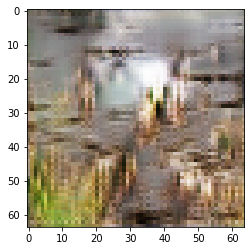

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.062180995941162 sec
Gen loss: 4.120487011545073, Disc loss: 0.5135241628985417
Time for epoch 2 is 13.145450115203857 sec
Gen loss: 4.346407805031877, Disc loss: 0.5179990001002625
Time for epoch 3 is 13.074540853500366 sec
Gen loss: 4.476171377228527, Disc loss: 0.4960745978484632
Time for epoch 4 is 13.073740720748901 sec
Gen loss: 4.192408395653494, Disc loss: 0.5010651470361364
Time for epoch 5 is 13.11604642868042 sec
Gen loss: 4.265342724032518, Disc loss: 0.5001287889997488
Time for epoch 6 is 13.17124891281128 sec
Gen loss: 4.070165939124296, Disc loss: 0.5192072328513231
Time for epoch 7 is 13.095990419387817 sec
Gen loss: 4.369717192197557, Disc loss: 0.48683691913196386
Time for epoch 8 is 13.079930782318115 sec
Gen loss: 4.333687333879755, Disc loss: 0.4881890049471765
Time for epoch 9 is 13.07654857635498 sec
Gen loss: 4.136143029220705

Time for epoch 80 is 13.086284875869751 sec
Gen loss: 4.661244513219611, Disc loss: 0.4594749022467027
Time for epoch 81 is 13.086669206619263 sec
Gen loss: 4.349473093906393, Disc loss: 0.4943544618320982
Time for epoch 82 is 13.077727317810059 sec
Gen loss: 4.359400870031134, Disc loss: 0.47144388482176514
Time for epoch 83 is 13.115346193313599 sec
Gen loss: 4.577544983809556, Disc loss: 0.46613892888635156
Time for epoch 84 is 13.200169563293457 sec
Gen loss: 4.404538237305514, Disc loss: 0.48317126142300243
Time for epoch 85 is 13.383801698684692 sec
Gen loss: 4.551892106772115, Disc loss: 0.45974432485213446
Time for epoch 86 is 13.395280361175537 sec
Gen loss: 4.779319889177152, Disc loss: 0.4756686842538477
Time for epoch 87 is 13.51063585281372 sec
Gen loss: 4.296475432429533, Disc loss: 0.4954531133821017
Time for epoch 88 is 13.350641250610352 sec
Gen loss: 4.251885742352907, Disc loss: 0.4859229029840247
Time for epoch 89 is 13.327104091644287 sec
Gen loss: 4.52265307896828

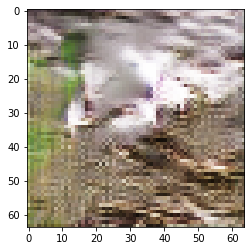

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 2

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.091082572937012 sec
Gen loss: 4.483375677248326, Disc loss: 0.46861926189606107
Time for epoch 2 is 13.157373428344727 sec
Gen loss: 4.470625335285011, Disc loss: 0.47120486034287346
Time for epoch 3 is 13.144514322280884 sec
Gen loss: 4.668467679967079, Disc loss: 0.4763447277268097
Time for epoch 4 is 13.090412616729736 sec
Gen loss: 4.464508305397137, Disc loss: 0.47358335380954797
Time for epoch 5 is 13.099557161331177 sec
Gen loss: 4.523046744871269, Disc loss: 0.47690368288254675
Time for epoch 6 is 13.177880764007568 sec
Gen loss: 4.315853713973751, Disc loss: 0.48753511744139966
Time for epoch 7 is 13.1049165725708 sec
Gen loss: 4.5094564956055105, Disc loss: 0.4777293548512911
Time for epoch 8 is 13.090446710586548 sec
Gen loss: 4.5525310213972885, Disc loss: 0.46432199775364985
Time for epoch 9 is 13.171169757843018 sec
Gen loss: 4.4572216

Time for epoch 80 is 13.137393951416016 sec
Gen loss: 4.291987689853038, Disc loss: 0.48810054454700086
Time for epoch 81 is 13.065469026565552 sec
Gen loss: 4.302391916755738, Disc loss: 0.48779138890385304
Time for epoch 82 is 13.104851245880127 sec
Gen loss: 4.327024225297013, Disc loss: 0.4892894103113552
Time for epoch 83 is 13.151655435562134 sec
Gen loss: 4.323202545403788, Disc loss: 0.48707273602485657
Time for epoch 84 is 13.114896774291992 sec
Gen loss: 4.377634251343848, Disc loss: 0.48287890314409726
Time for epoch 85 is 13.061703205108643 sec
Gen loss: 4.502938709930999, Disc loss: 0.48820135893860483
Time for epoch 86 is 13.075402975082397 sec
Gen loss: 4.22361205522284, Disc loss: 0.49611985239233103
Time for epoch 87 is 13.059604167938232 sec
Gen loss: 4.224030589669701, Disc loss: 0.4920560849229818
Time for epoch 88 is 13.058632135391235 sec
Gen loss: 4.294854504629202, Disc loss: 0.486173764315401
Time for epoch 89 is 13.143839597702026 sec
Gen loss: 4.5778058059816

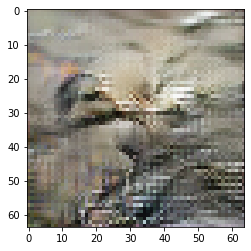

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 3

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.081564903259277 sec
Gen loss: 4.385549553687657, Disc loss: 0.476602737577304
Time for epoch 2 is 13.070239305496216 sec
Gen loss: 4.643573980021283, Disc loss: 0.48193535814440347
Time for epoch 3 is 13.138436079025269 sec
Gen loss: 4.352056007075116, Disc loss: 0.47590006399283885
Time for epoch 4 is 13.124586343765259 sec
Gen loss: 4.404338377278026, Disc loss: 0.47340830247899707
Time for epoch 5 is 13.08434796333313 sec
Gen loss: 4.50330921046456, Disc loss: 0.4789880548873891
Time for epoch 6 is 13.104146957397461 sec
Gen loss: 4.482273702052874, Disc loss: 0.4775137157459569
Time for epoch 7 is 13.124417781829834 sec
Gen loss: 4.4431629484584985, Disc loss: 0.4775926534560961
Time for epoch 8 is 13.084686517715454 sec
Gen loss: 4.5083674912853295, Disc loss: 0.47834280545149394
Time for epoch 9 is 13.09799313545227 sec
Gen loss: 4.37874241185

Time for epoch 80 is 13.178497791290283 sec
Gen loss: 4.227646766962398, Disc loss: 0.4962116556600503
Time for epoch 81 is 13.07547640800476 sec
Gen loss: 4.332310092481494, Disc loss: 0.4955685031284808
Time for epoch 82 is 13.071621417999268 sec
Gen loss: 4.351844831533872, Disc loss: 0.49400815141556387
Time for epoch 83 is 13.095927238464355 sec
Gen loss: 4.3842304592856225, Disc loss: 0.4945669063546147
Time for epoch 84 is 13.115617275238037 sec
Gen loss: 4.072641372680664, Disc loss: 0.4951412939443821
Time for epoch 85 is 13.077538251876831 sec
Gen loss: 4.269563824826786, Disc loss: 0.49746512114840147
Time for epoch 86 is 13.10816478729248 sec
Gen loss: 4.279657383275226, Disc loss: 0.4994503398574788
Time for epoch 87 is 13.126838684082031 sec
Gen loss: 4.245293404674788, Disc loss: 0.4842673851060997
Time for epoch 88 is 13.08794379234314 sec
Gen loss: 4.161642992722633, Disc loss: 0.4967254264567926
Time for epoch 89 is 13.098220348358154 sec
Gen loss: 4.2853537200266105,

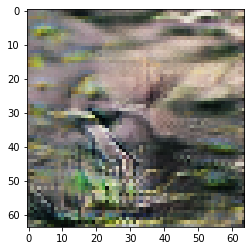

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 4

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.09528398513794 sec
Gen loss: 4.040651919719004, Disc loss: 0.49709167680766203
Time for epoch 2 is 13.074473857879639 sec
Gen loss: 4.148976468135348, Disc loss: 0.4985873288901518
Time for epoch 3 is 13.127362728118896 sec
Gen loss: 4.346059584036106, Disc loss: 0.5005330287505617
Time for epoch 4 is 13.13201379776001 sec
Gen loss: 4.251961551707612, Disc loss: 0.4925292983126188
Time for epoch 5 is 13.070090770721436 sec
Gen loss: 4.149634020115302, Disc loss: 0.5064527334236517
Time for epoch 6 is 13.065676927566528 sec
Gen loss: 4.305566556408476, Disc loss: 0.4933320619064941
Time for epoch 7 is 13.065927267074585 sec
Gen loss: 4.236457466109981, Disc loss: 0.5055051411232006
Time for epoch 8 is 13.157421112060547 sec
Gen loss: 4.142969662581033, Disc loss: 0.49620148184176704
Time for epoch 9 is 13.083678483963013 sec
Gen loss: 4.3247307606828

Time for epoch 80 is 13.090331315994263 sec
Gen loss: 4.1872504500515735, Disc loss: 0.49474849844689617
Time for epoch 81 is 13.14790964126587 sec
Gen loss: 4.343529291592316, Disc loss: 0.492530581831609
Time for epoch 82 is 13.079239845275879 sec
Gen loss: 4.348489708370632, Disc loss: 0.49570304405721544
Time for epoch 83 is 13.09500002861023 sec
Gen loss: 4.235905171086794, Disc loss: 0.49568185266763537
Time for epoch 84 is 13.117913961410522 sec
Gen loss: 4.19810860654526, Disc loss: 0.4960533139828421
Time for epoch 85 is 13.06997013092041 sec
Gen loss: 4.211631345878126, Disc loss: 0.5018392088936596
Time for epoch 86 is 13.114804029464722 sec
Gen loss: 4.281366749507625, Disc loss: 0.49298277505368077
Time for epoch 87 is 13.084580659866333 sec
Gen loss: 4.242770524528938, Disc loss: 0.49316217938089757
Time for epoch 88 is 13.077105522155762 sec
Gen loss: 4.211084181700295, Disc loss: 0.5011064055650861
Time for epoch 89 is 13.113719463348389 sec
Gen loss: 4.225200209191175,

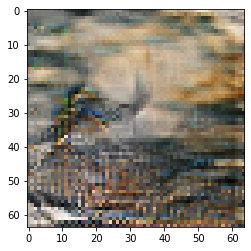

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 5

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.108678579330444 sec
Gen loss: 4.265349426243686, Disc loss: 0.4891957201285737
Time for epoch 2 is 13.070313692092896 sec
Gen loss: 4.287887582287879, Disc loss: 0.4985759654826911
Time for epoch 3 is 13.08040475845337 sec
Gen loss: 4.32405614659069, Disc loss: 0.49684073818408375
Time for epoch 4 is 13.120752573013306 sec
Gen loss: 4.15854664223627, Disc loss: 0.4945285252439297
Time for epoch 5 is 13.066216945648193 sec
Gen loss: 4.28214149423408, Disc loss: 0.49377292685392427
Time for epoch 6 is 13.080285549163818 sec
Gen loss: 4.275286456110678, Disc loss: 0.5063801186517648
Time for epoch 7 is 13.069678544998169 sec
Gen loss: 4.1882411871499166, Disc loss: 0.4969869484584829
Time for epoch 8 is 13.100274562835693 sec
Gen loss: 4.171928034888373, Disc loss: 0.4938398903301415
Time for epoch 9 is 13.123352766036987 sec
Gen loss: 4.16927361552954

Time for epoch 80 is 13.081453084945679 sec
Gen loss: 4.066878544282784, Disc loss: 0.5198997998948343
Time for epoch 81 is 13.065452337265015 sec
Gen loss: 4.060828446049677, Disc loss: 0.5183920403967704
Time for epoch 82 is 13.14151406288147 sec
Gen loss: 4.094460459582528, Disc loss: 0.511169690265242
Time for epoch 83 is 13.101407527923584 sec
Gen loss: 4.166223350902237, Disc loss: 0.5041568130658571
Time for epoch 84 is 13.093015193939209 sec
Gen loss: 4.242062890432714, Disc loss: 0.5117236030941733
Time for epoch 85 is 13.090294599533081 sec
Gen loss: 3.9904174649618507, Disc loss: 0.5197303463126909
Time for epoch 86 is 13.072344064712524 sec
Gen loss: 4.079629403788869, Disc loss: 0.5209980671644857
Time for epoch 87 is 13.071628332138062 sec
Gen loss: 4.255387600844468, Disc loss: 0.5051973657556342
Time for epoch 88 is 13.087494373321533 sec
Gen loss: 3.8567677791202617, Disc loss: 0.5341642613656475
Time for epoch 89 is 13.0819833278656 sec
Gen loss: 3.9084442249804656, D

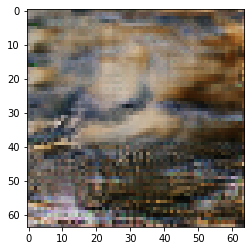

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 6

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.08009147644043 sec
Gen loss: 3.9486049223075392, Disc loss: 0.5209699270686483
Time for epoch 2 is 13.092702388763428 sec
Gen loss: 3.9443629078748748, Disc loss: 0.520590964452361
Time for epoch 3 is 13.054917335510254 sec
Gen loss: 4.089856117398435, Disc loss: 0.5235170965918358
Time for epoch 4 is 13.083753824234009 sec
Gen loss: 4.061676634036429, Disc loss: 0.5245331233432946
Time for epoch 5 is 13.137640237808228 sec
Gen loss: 3.856185276010818, Disc loss: 0.5325541384821015
Time for epoch 6 is 13.107580661773682 sec
Gen loss: 4.126490004340485, Disc loss: 0.5248380911544086
Time for epoch 7 is 13.069485425949097 sec
Gen loss: 3.8368984832350153, Disc loss: 0.5226179295923652
Time for epoch 8 is 13.069165706634521 sec
Gen loss: 4.021166763331509, Disc loss: 0.5179470040933872
Time for epoch 9 is 13.171797275543213 sec
Gen loss: 4.002988291949

Time for epoch 80 is 13.076629161834717 sec
Gen loss: 4.08167276343679, Disc loss: 0.5147922057607955
Time for epoch 81 is 13.083514928817749 sec
Gen loss: 4.010347109176926, Disc loss: 0.5339776671675809
Time for epoch 82 is 13.10747742652893 sec
Gen loss: 4.125591318781783, Disc loss: 0.52019894607668
Time for epoch 83 is 13.103290557861328 sec
Gen loss: 3.982914689433607, Disc loss: 0.5325887610272664
Time for epoch 84 is 13.091016054153442 sec
Gen loss: 3.9112537856993637, Disc loss: 0.5292649708466155
Time for epoch 85 is 13.09929633140564 sec
Gen loss: 4.0175846553430326, Disc loss: 0.5275062264465704
Time for epoch 86 is 13.084537267684937 sec
Gen loss: 4.033022532941203, Disc loss: 0.5227751758525042
Time for epoch 87 is 13.07808232307434 sec
Gen loss: 4.0053812804907, Disc loss: 0.5226734260394967
Time for epoch 88 is 13.062309265136719 sec
Gen loss: 4.079251961333319, Disc loss: 0.5253611420228229
Time for epoch 89 is 13.066498756408691 sec
Gen loss: 4.0077725555192485, Disc 

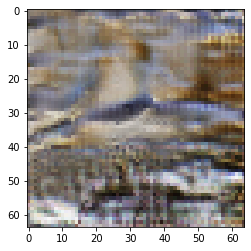

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 7

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.112670183181763 sec
Gen loss: 3.9663903887678935, Disc loss: 0.5288550455557298
Time for epoch 2 is 13.093090772628784 sec
Gen loss: 3.9272039621503048, Disc loss: 0.5276794713041001
Time for epoch 3 is 13.084867238998413 sec
Gen loss: 4.0047913037018406, Disc loss: 0.5333144647803733
Time for epoch 4 is 13.058844566345215 sec
Gen loss: 4.065470283916649, Disc loss: 0.5306220255731567
Time for epoch 5 is 13.059518098831177 sec
Gen loss: 4.017134340797982, Disc loss: 0.5267489065484303
Time for epoch 6 is 13.114501714706421 sec
Gen loss: 3.92242505750682, Disc loss: 0.5312444888317811
Time for epoch 7 is 13.09272050857544 sec
Gen loss: 4.012689600792035, Disc loss: 0.5227840967617707
Time for epoch 8 is 13.09498643875122 sec
Gen loss: 4.002267672117487, Disc loss: 0.5358948953106475
Time for epoch 9 is 13.08697247505188 sec
Gen loss: 3.96434506038986

Time for epoch 80 is 13.090163230895996 sec
Gen loss: 4.021599976997066, Disc loss: 0.5313277209838878
Time for epoch 81 is 13.114699840545654 sec
Gen loss: 3.9815373543478287, Disc loss: 0.5357811480033688
Time for epoch 82 is 13.084788799285889 sec
Gen loss: 3.8767466260811823, Disc loss: 0.5325595778501454
Time for epoch 83 is 13.158504009246826 sec
Gen loss: 3.9647492257560173, Disc loss: 0.5341002274011855
Time for epoch 84 is 13.054693222045898 sec
Gen loss: 3.912200569137325, Disc loss: 0.5343737236367978
Time for epoch 85 is 13.09702205657959 sec
Gen loss: 3.8973455926590175, Disc loss: 0.5375979688109421
Time for epoch 86 is 13.113525867462158 sec
Gen loss: 3.9468755599282943, Disc loss: 0.5331509924193385
Time for epoch 87 is 13.0874183177948 sec
Gen loss: 3.938935816772585, Disc loss: 0.5284918437643749
Time for epoch 88 is 13.097402334213257 sec
Gen loss: 3.901248841427852, Disc loss: 0.5327296747263208
Time for epoch 89 is 13.109333038330078 sec
Gen loss: 4.035853712216302

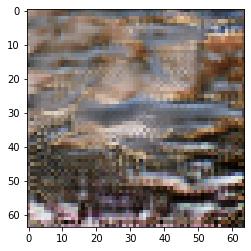

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 8

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.131645679473877 sec
Gen loss: 3.8949955130011085, Disc loss: 0.5320656627497375
Time for epoch 2 is 13.123528718948364 sec
Gen loss: 3.9759973103437964, Disc loss: 0.5471576776123306
Time for epoch 3 is 13.0799720287323 sec
Gen loss: 3.9365875365611336, Disc loss: 0.5365641787446288
Time for epoch 4 is 13.070489645004272 sec
Gen loss: 3.9009113899737518, Disc loss: 0.5406255554054488
Time for epoch 5 is 13.105300426483154 sec
Gen loss: 3.982076675265139, Disc loss: 0.536559566734283
Time for epoch 6 is 13.128834009170532 sec
Gen loss: 3.967901832042994, Disc loss: 0.5470529003195
Time for epoch 7 is 13.113677263259888 sec
Gen loss: 3.8248296740255383, Disc loss: 0.5413335508447352
Time for epoch 8 is 13.108313083648682 sec
Gen loss: 3.948853677527368, Disc loss: 0.5361292192606422
Time for epoch 9 is 13.057274341583252 sec
Gen loss: 4.00541587767562

Time for epoch 80 is 13.122288942337036 sec
Gen loss: 3.888328977393587, Disc loss: 0.5398931764167175
Time for epoch 81 is 13.093621730804443 sec
Gen loss: 3.9116477178041205, Disc loss: 0.5449442471753614
Time for epoch 82 is 13.077871322631836 sec
Gen loss: 4.0084372432574344, Disc loss: 0.5405674210085778
Time for epoch 83 is 13.107010126113892 sec
Gen loss: 3.875449314996156, Disc loss: 0.5372632529515884
Time for epoch 84 is 13.101787328720093 sec
Gen loss: 3.9529688461686217, Disc loss: 0.5401074367810071
Time for epoch 85 is 13.127067804336548 sec
Gen loss: 3.9397948641117995, Disc loss: 0.5453620001391021
Time for epoch 86 is 13.091708898544312 sec
Gen loss: 3.948721998752294, Disc loss: 0.5378068503002488
Time for epoch 87 is 13.064511775970459 sec
Gen loss: 3.9318958621038007, Disc loss: 0.5416033156519013
Time for epoch 88 is 13.107684135437012 sec
Gen loss: 3.806053342534921, Disc loss: 0.5479027364796739
Time for epoch 89 is 13.101500988006592 sec
Gen loss: 3.876945812204

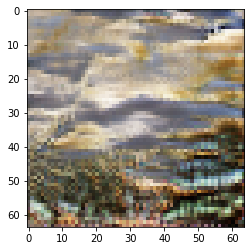

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 9

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.091373205184937 sec
Gen loss: 3.853639642720623, Disc loss: 0.5409819581482792
Time for epoch 2 is 13.134975671768188 sec
Gen loss: 4.0430215884676475, Disc loss: 0.5350487028680196
Time for epoch 3 is 13.122297048568726 sec
Gen loss: 3.84577627621369, Disc loss: 0.5475710292818746
Time for epoch 4 is 13.103044033050537 sec
Gen loss: 3.918321818840213, Disc loss: 0.5466283639756645
Time for epoch 5 is 13.069050788879395 sec
Gen loss: 3.910523691797644, Disc loss: 0.5382189076282791
Time for epoch 6 is 13.06334900856018 sec
Gen loss: 3.8911611077585193, Disc loss: 0.5408879077531458
Time for epoch 7 is 13.110233783721924 sec
Gen loss: 3.883212625818847, Disc loss: 0.5451353684996525
Time for epoch 8 is 13.085786581039429 sec
Gen loss: 3.9025218570781592, Disc loss: 0.5387346364133726
Time for epoch 9 is 13.087459325790405 sec
Gen loss: 3.893313818830

Time for epoch 80 is 13.093435287475586 sec
Gen loss: 3.825622083048833, Disc loss: 0.555021678852195
Time for epoch 81 is 13.07106900215149 sec
Gen loss: 3.770455269955684, Disc loss: 0.5566556006266172
Time for epoch 82 is 13.061373949050903 sec
Gen loss: 3.8327896032876114, Disc loss: 0.5579214475665312
Time for epoch 83 is 13.089254140853882 sec
Gen loss: 3.813685638794731, Disc loss: 0.5517109328815284
Time for epoch 84 is 13.111369848251343 sec
Gen loss: 3.856375848697776, Disc loss: 0.5477818243387269
Time for epoch 85 is 13.153917789459229 sec
Gen loss: 3.7921807410594246, Disc loss: 0.5535039164348023
Time for epoch 86 is 13.067542314529419 sec
Gen loss: 3.7926751326739305, Disc loss: 0.5600134072103474
Time for epoch 87 is 13.131754875183105 sec
Gen loss: 3.837385728107235, Disc loss: 0.5492957953999682
Time for epoch 88 is 13.081782341003418 sec
Gen loss: 3.861082817480816, Disc loss: 0.5499539208929067
Time for epoch 89 is 13.070915460586548 sec
Gen loss: 3.802432087378773,

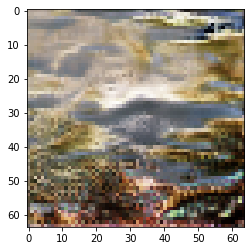

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 10

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.055679559707642 sec
Gen loss: 3.7420181633657235, Disc loss: 0.5546457029293547
Time for epoch 2 is 13.131641626358032 sec
Gen loss: 3.8791167509911184, Disc loss: 0.5505955466410009
Time for epoch 3 is 13.158651113510132 sec
Gen loss: 3.862852447401217, Disc loss: 0.5545425710639333
Time for epoch 4 is 13.119152307510376 sec
Gen loss: 3.81099465481311, Disc loss: 0.5562706103492882
Time for epoch 5 is 13.05725622177124 sec
Gen loss: 3.825209481283255, Disc loss: 0.5542220592014189
Time for epoch 6 is 13.099049806594849 sec
Gen loss: 3.7854180000015716, Disc loss: 0.5479995763398767
Time for epoch 7 is 13.104850053787231 sec
Gen loss: 3.8980658538942414, Disc loss: 0.5480171391149846
Time for epoch 8 is 13.092579364776611 sec
Gen loss: 3.8409308476176687, Disc loss: 0.5483814213011
Time for epoch 9 is 13.097899675369263 sec
Gen loss: 3.895428691130

Time for epoch 80 is 13.08837103843689 sec
Gen loss: 3.8127850930542158, Disc loss: 0.5535016795645561
Time for epoch 81 is 13.105589628219604 sec
Gen loss: 3.8884380154493376, Disc loss: 0.5513999559853459
Time for epoch 82 is 13.119981527328491 sec
Gen loss: 3.889160947101872, Disc loss: 0.5408405309447105
Time for epoch 83 is 13.129822731018066 sec
Gen loss: 3.9223524025139125, Disc loss: 0.5567326218616672
Time for epoch 84 is 13.09716796875 sec
Gen loss: 3.8413788807101366, Disc loss: 0.5516250054364605
Time for epoch 85 is 13.15303897857666 sec
Gen loss: 3.8829012808760974, Disc loss: 0.5570044567591452
Time for epoch 86 is 13.103305101394653 sec
Gen loss: 3.847946205759436, Disc loss: 0.549476318889194
Time for epoch 87 is 13.16072940826416 sec
Gen loss: 3.926899672846807, Disc loss: 0.54438355484306
Time for epoch 88 is 13.074490547180176 sec
Gen loss: 3.857942373125857, Disc loss: 0.55037656224517
Time for epoch 89 is 13.11819052696228 sec
Gen loss: 3.8704320693080665, Disc lo

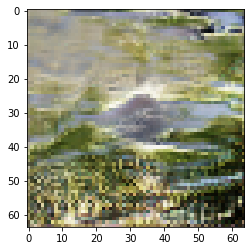

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 11

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.085918188095093 sec
Gen loss: 3.8715655829525253, Disc loss: 0.5448554981207137
Time for epoch 2 is 13.110788583755493 sec
Gen loss: 3.904914417241001, Disc loss: 0.5442414892721306
Time for epoch 3 is 13.155452966690063 sec
Gen loss: 3.8364088160558767, Disc loss: 0.5552208523763228
Time for epoch 4 is 13.136284351348877 sec
Gen loss: 3.8155748585698404, Disc loss: 0.5527519084573761
Time for epoch 5 is 13.075430631637573 sec
Gen loss: 3.852210793714859, Disc loss: 0.5564808393235452
Time for epoch 6 is 13.060192108154297 sec
Gen loss: 3.791570770708203, Disc loss: 0.5562535388682915
Time for epoch 7 is 13.06213903427124 sec
Gen loss: 3.8403146266937256, Disc loss: 0.5513323140822775
Time for epoch 8 is 13.081111431121826 sec
Gen loss: 3.840405901596152, Disc loss: 0.5500538425878457
Time for epoch 9 is 13.072997570037842 sec
Gen loss: 3.846590823

Time for epoch 80 is 13.09573745727539 sec
Gen loss: 4.002949302435567, Disc loss: 0.5418933003252437
Time for epoch 81 is 13.096296310424805 sec
Gen loss: 3.831306792210111, Disc loss: 0.5539017515938457
Time for epoch 82 is 13.086246728897095 sec
Gen loss: 3.862840090340715, Disc loss: 0.5488188828879256
Time for epoch 83 is 13.068734884262085 sec
Gen loss: 3.941735980310414, Disc loss: 0.548273749306273
Time for epoch 84 is 13.1132652759552 sec
Gen loss: 3.9089672274705842, Disc loss: 0.5527069409526784
Time for epoch 85 is 13.087454080581665 sec
Gen loss: 3.8150827884674072, Disc loss: 0.5535342773286308
Time for epoch 86 is 13.122515678405762 sec
Gen loss: 3.90265653837664, Disc loss: 0.5523813966974657
Time for epoch 87 is 13.102548837661743 sec
Gen loss: 3.803809942591804, Disc loss: 0.5475599267456913
Time for epoch 88 is 13.074634552001953 sec
Gen loss: 3.8942590082887065, Disc loss: 0.5446611971551487
Time for epoch 89 is 13.10174822807312 sec
Gen loss: 3.9602161164529277, Di

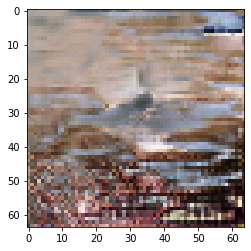

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 12

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.089534759521484 sec
Gen loss: 3.922986979730084, Disc loss: 0.5489956873865308
Time for epoch 2 is 13.090889930725098 sec
Gen loss: 3.7597078004180577, Disc loss: 0.5548686956971641
Time for epoch 3 is 13.065254926681519 sec
Gen loss: 3.948614225801091, Disc loss: 0.5447233370164546
Time for epoch 4 is 13.134998321533203 sec
Gen loss: 3.812105035394188, Disc loss: 0.5585189095034508
Time for epoch 5 is 13.106964826583862 sec
Gen loss: 3.901963120230491, Disc loss: 0.5488326476033787
Time for epoch 6 is 13.085791110992432 sec
Gen loss: 3.8235515572514314, Disc loss: 0.5498289402907457
Time for epoch 7 is 13.093549966812134 sec
Gen loss: 3.8952750487702326, Disc loss: 0.5487777578636883
Time for epoch 8 is 13.075418472290039 sec
Gen loss: 3.9473724643066324, Disc loss: 0.552937590898214
Time for epoch 9 is 13.10498857498169 sec
Gen loss: 3.9560443088

Time for epoch 80 is 13.060702800750732 sec
Gen loss: 4.040758944462309, Disc loss: 0.5477624541214166
Time for epoch 81 is 13.135159015655518 sec
Gen loss: 3.8152248400659743, Disc loss: 0.5598559025826493
Time for epoch 82 is 13.09570837020874 sec
Gen loss: 3.7824587557050915, Disc loss: 0.5585596152760472
Time for epoch 83 is 13.121129751205444 sec
Gen loss: 3.9048837781921635, Disc loss: 0.5471786876034931
Time for epoch 84 is 13.062825918197632 sec
Gen loss: 3.8656031019319363, Disc loss: 0.5574830327092147
Time for epoch 85 is 13.114975929260254 sec
Gen loss: 3.794731647987676, Disc loss: 0.5554801782133779
Time for epoch 86 is 13.140923976898193 sec
Gen loss: 3.8239680938927463, Disc loss: 0.5543828594490765
Time for epoch 87 is 13.141396284103394 sec
Gen loss: 3.8679438884342265, Disc loss: 0.5523577510179866
Time for epoch 88 is 13.089374542236328 sec
Gen loss: 3.78917158522257, Disc loss: 0.556794354343802
Time for epoch 89 is 13.066312313079834 sec
Gen loss: 3.79357422464262

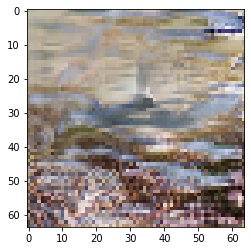

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 13

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.104530572891235 sec
Gen loss: 3.8489706225511506, Disc loss: 0.55223571131546
Time for epoch 2 is 13.102633953094482 sec
Gen loss: 3.8755431750279454, Disc loss: 0.5509276887588708
Time for epoch 3 is 13.088254928588867 sec
Gen loss: 3.931406245968206, Disc loss: 0.548354450926225
Time for epoch 4 is 13.08220887184143 sec
Gen loss: 3.7927060624771327, Disc loss: 0.5624915337174888
Time for epoch 5 is 13.176046371459961 sec
Gen loss: 3.7905373935130875, Disc loss: 0.5560770342505075
Time for epoch 6 is 13.10561203956604 sec
Gen loss: 3.8695723280351015, Disc loss: 0.5504433037788887
Time for epoch 7 is 13.06288194656372 sec
Gen loss: 3.8448536182806743, Disc loss: 0.5561431481586239
Time for epoch 8 is 13.073418617248535 sec
Gen loss: 3.837077480021531, Disc loss: 0.5532138625457681
Time for epoch 9 is 13.091171026229858 sec
Gen loss: 3.895862369356

Time for epoch 80 is 13.06642770767212 sec
Gen loss: 3.861177071000179, Disc loss: 0.5563569725528965
Time for epoch 81 is 13.05948805809021 sec
Gen loss: 3.852728569733741, Disc loss: 0.559672745020409
Time for epoch 82 is 13.09256911277771 sec
Gen loss: 3.8553176436643937, Disc loss: 0.5548828994517081
Time for epoch 83 is 13.076753616333008 sec
Gen loss: 3.7820201520997334, Disc loss: 0.5605944655936584
Time for epoch 84 is 13.112990140914917 sec
Gen loss: 3.7770511457913614, Disc loss: 0.556013100434771
Time for epoch 85 is 13.119991302490234 sec
Gen loss: 3.8840243751763652, Disc loss: 0.550722496134802
Time for epoch 86 is 13.12319302558899 sec
Gen loss: 3.8898708439131737, Disc loss: 0.5503452717450253
Time for epoch 87 is 13.172709226608276 sec
Gen loss: 3.9275307758713804, Disc loss: 0.551196325762162
Time for epoch 88 is 13.058193683624268 sec
Gen loss: 3.7529634938330507, Disc loss: 0.5562145441043668
Time for epoch 89 is 13.053043127059937 sec
Gen loss: 3.8479410090097566, 

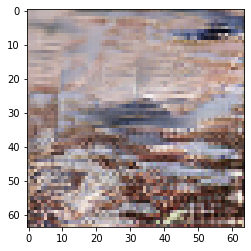

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 14

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.146472215652466 sec
Gen loss: 3.8745944932870424, Disc loss: 0.5533669114435914
Time for epoch 2 is 13.111479043960571 sec
Gen loss: 3.89392486820376, Disc loss: 0.5570097523653087
Time for epoch 3 is 13.06543493270874 sec
Gen loss: 3.8082002663030856, Disc loss: 0.5567066770420488
Time for epoch 4 is 13.065404891967773 sec
Gen loss: 3.932701768590829, Disc loss: 0.5521031577735735
Time for epoch 5 is 13.097107648849487 sec
Gen loss: 3.817178648015671, Disc loss: 0.554019155864147
Time for epoch 6 is 13.177749156951904 sec
Gen loss: 3.8301870680759915, Disc loss: 0.5571947130892012
Time for epoch 7 is 13.137133359909058 sec
Gen loss: 3.858413454639879, Disc loss: 0.5572478772017367
Time for epoch 8 is 13.09952688217163 sec
Gen loss: 3.8010896912758265, Disc loss: 0.5609838398814524
Time for epoch 9 is 13.109192371368408 sec
Gen loss: 3.872907834970

Time for epoch 80 is 13.084532976150513 sec
Gen loss: 3.854501325586624, Disc loss: 0.5563658223081087
Time for epoch 81 is 13.14891242980957 sec
Gen loss: 3.812825402593225, Disc loss: 0.5524320982012968
Time for epoch 82 is 13.057766199111938 sec
Gen loss: 3.818316230928995, Disc loss: 0.5613302709610482
Time for epoch 83 is 13.061402082443237 sec
Gen loss: 3.7502752868786735, Disc loss: 0.5603466617059578
Time for epoch 84 is 13.119550704956055 sec
Gen loss: 3.869834571672972, Disc loss: 0.5476664572065761
Time for epoch 85 is 13.113247156143188 sec
Gen loss: 3.8498276772537854, Disc loss: 0.5608964093978489
Time for epoch 86 is 13.113698244094849 sec
Gen loss: 3.7998413290111674, Disc loss: 0.561980926974356
Time for epoch 87 is 13.095665454864502 sec
Gen loss: 3.7585238221538098, Disc loss: 0.5654710880139979
Time for epoch 88 is 13.146166324615479 sec
Gen loss: 3.7494913368690304, Disc loss: 0.5586146802760075
Time for epoch 89 is 13.10663890838623 sec
Gen loss: 3.833093499103535

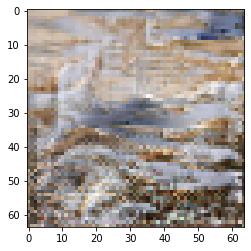

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 15

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.103343725204468 sec
Gen loss: 3.7839022580847184, Disc loss: 0.5586316062182914
Time for epoch 2 is 13.099556922912598 sec
Gen loss: 3.8686534951372846, Disc loss: 0.5572648616987192
Time for epoch 3 is 13.109917640686035 sec
Gen loss: 3.8321377035725086, Disc loss: 0.5574729276220327
Time for epoch 4 is 13.109637975692749 sec
Gen loss: 3.926809866576983, Disc loss: 0.5541494456410085
Time for epoch 5 is 13.120210647583008 sec
Gen loss: 3.793269727288223, Disc loss: 0.5631540067150664
Time for epoch 6 is 13.125671863555908 sec
Gen loss: 3.7281794308969967, Disc loss: 0.5639440668469199
Time for epoch 7 is 13.106734991073608 sec
Gen loss: 3.8611388238787976, Disc loss: 0.5613119372830482
Time for epoch 8 is 13.096236944198608 sec
Gen loss: 3.7735831343384616, Disc loss: 0.5609053567980686
Time for epoch 9 is 13.083750247955322 sec
Gen loss: 3.824822

Time for epoch 80 is 13.125389575958252 sec
Gen loss: 3.8347284186500197, Disc loss: 0.5555584783638073
Time for epoch 81 is 13.07575511932373 sec
Gen loss: 3.7772951255322793, Disc loss: 0.5601357661773195
Time for epoch 82 is 13.088660955429077 sec
Gen loss: 3.8452554698882064, Disc loss: 0.5526336927401018
Time for epoch 83 is 13.118270635604858 sec
Gen loss: 3.967294980516925, Disc loss: 0.5467845430057546
Time for epoch 84 is 13.121086359024048 sec
Gen loss: 3.832152039054933, Disc loss: 0.5661561857394086
Time for epoch 85 is 13.104557752609253 sec
Gen loss: 3.7482451164948585, Disc loss: 0.5609503707426996
Time for epoch 86 is 13.095522403717041 sec
Gen loss: 3.7951983966155427, Disc loss: 0.5557032430236578
Time for epoch 87 is 13.088908195495605 sec
Gen loss: 3.8639363841958807, Disc loss: 0.5575194920143138
Time for epoch 88 is 13.109744310379028 sec
Gen loss: 3.9070758722661956, Disc loss: 0.5521624291007757
Time for epoch 89 is 13.151366233825684 sec
Gen loss: 3.86910591862

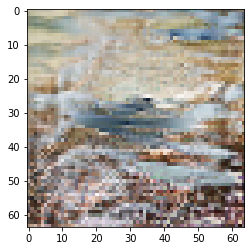

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 16

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.104318380355835 sec
Gen loss: 3.7834838864603015, Disc loss: 0.5596940391431979
Time for epoch 2 is 13.083272218704224 sec
Gen loss: 3.8578817514869255, Disc loss: 0.5568784433328685
Time for epoch 3 is 13.101090669631958 sec
Gen loss: 3.774980010702035, Disc loss: 0.5567408315534514
Time for epoch 4 is 13.099413871765137 sec
Gen loss: 3.8585263668360104, Disc loss: 0.5583561124194282
Time for epoch 5 is 13.07891845703125 sec
Gen loss: 3.732367358556608, Disc loss: 0.5653750896453857
Time for epoch 6 is 13.122322082519531 sec
Gen loss: 3.813074049910879, Disc loss: 0.5597159688873343
Time for epoch 7 is 13.171014308929443 sec
Gen loss: 3.812584615981353, Disc loss: 0.5541856887379313
Time for epoch 8 is 13.097431898117065 sec
Gen loss: 3.785889810339868, Disc loss: 0.5576365204845987
Time for epoch 9 is 13.115742206573486 sec
Gen loss: 3.8117757832

Time for epoch 80 is 13.119842052459717 sec
Gen loss: 3.9323976905688363, Disc loss: 0.5546377054074916
Time for epoch 81 is 13.084104537963867 sec
Gen loss: 3.808939907932023, Disc loss: 0.5623869340271161
Time for epoch 82 is 13.095896482467651 sec
Gen loss: 3.80949245041948, Disc loss: 0.5597086803215306
Time for epoch 83 is 13.075398206710815 sec
Gen loss: 3.8171029213644303, Disc loss: 0.5584632175240091
Time for epoch 84 is 13.089922428131104 sec
Gen loss: 3.8942029049726035, Disc loss: 0.5578606555940013
Time for epoch 85 is 13.071278095245361 sec
Gen loss: 3.8019690629912586, Disc loss: 0.5596553818966316
Time for epoch 86 is 13.095295190811157 sec
Gen loss: 3.8591768160098936, Disc loss: 0.5537625405846572
Time for epoch 87 is 13.07942008972168 sec
Gen loss: 3.8669624929505635, Disc loss: 0.5519985360343281
Time for epoch 88 is 13.086305379867554 sec
Gen loss: 3.865526441636124, Disc loss: 0.5595743266870659
Time for epoch 89 is 13.094470739364624 sec
Gen loss: 3.8843535627452

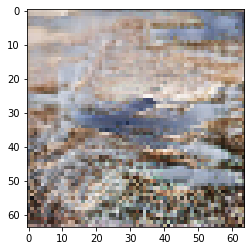

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 17

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.0658700466156 sec
Gen loss: 3.836352142861219, Disc loss: 0.5547157118152474
Time for epoch 2 is 13.122002601623535 sec
Gen loss: 3.784927973579262, Disc loss: 0.5633751597346329
Time for epoch 3 is 13.079142093658447 sec
Gen loss: 3.736962253162208, Disc loss: 0.5621339847563405
Time for epoch 4 is 13.073191404342651 sec
Gen loss: 3.850940235261995, Disc loss: 0.5552155713078776
Time for epoch 5 is 13.066910982131958 sec
Gen loss: 3.805801372217938, Disc loss: 0.5594772157791831
Time for epoch 6 is 13.063509702682495 sec
Gen loss: 3.795773767197358, Disc loss: 0.5608138605992645
Time for epoch 7 is 13.110365390777588 sec
Gen loss: 3.8559642884789445, Disc loss: 0.5558007970088865
Time for epoch 8 is 13.161580801010132 sec
Gen loss: 3.8613260289840907, Disc loss: 0.5531039636148024
Time for epoch 9 is 13.109763145446777 sec
Gen loss: 3.786978037376

Time for epoch 80 is 13.115550518035889 sec
Gen loss: 3.8920294650524934, Disc loss: 0.5500922093223427
Time for epoch 81 is 13.174208402633667 sec
Gen loss: 3.8436215117694887, Disc loss: 0.5547713185875074
Time for epoch 82 is 13.11460018157959 sec
Gen loss: 3.8316732971325798, Disc loss: 0.5608764086473925
Time for epoch 83 is 13.088369607925415 sec
Gen loss: 3.8339947284398685, Disc loss: 0.5516719763194965
Time for epoch 84 is 13.115084409713745 sec
Gen loss: 3.7771824362478283, Disc loss: 0.5599625139701657
Time for epoch 85 is 13.066578388214111 sec
Gen loss: 3.8949615767977748, Disc loss: 0.5558942842289685
Time for epoch 86 is 13.080076694488525 sec
Gen loss: 3.9331384745393665, Disc loss: 0.5533541117095688
Time for epoch 87 is 13.088186979293823 sec
Gen loss: 3.795515251030444, Disc loss: 0.5588831845822373
Time for epoch 88 is 13.102121353149414 sec
Gen loss: 3.8151533396909554, Disc loss: 0.556739952829149
Time for epoch 89 is 13.135315418243408 sec
Gen loss: 3.93720386215

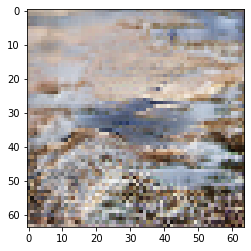

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 18

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.111063241958618 sec
Gen loss: 3.868882127570589, Disc loss: 0.5566431373600068
Time for epoch 2 is 13.110750198364258 sec
Gen loss: 3.757318853362789, Disc loss: 0.5634617367734108
Time for epoch 3 is 13.115126848220825 sec
Gen loss: 3.9001739516167784, Disc loss: 0.5467188368806348
Time for epoch 4 is 13.095415830612183 sec
Gen loss: 3.8416763489162373, Disc loss: 0.5566097577089862
Time for epoch 5 is 13.096028089523315 sec
Gen loss: 3.7689472013695777, Disc loss: 0.5658886940660193
Time for epoch 6 is 13.087104558944702 sec
Gen loss: 3.8754785539011967, Disc loss: 0.5541803022710289
Time for epoch 7 is 13.114763021469116 sec
Gen loss: 3.7800493472959937, Disc loss: 0.557845098781715
Time for epoch 8 is 13.11396050453186 sec
Gen loss: 3.820599857061536, Disc loss: 0.5612961322796054
Time for epoch 9 is 13.17836046218872 sec
Gen loss: 4.0229355520

Time for epoch 80 is 13.110002517700195 sec
Gen loss: 3.7992749343396524, Disc loss: 0.5614937144889418
Time for epoch 81 is 13.152514696121216 sec
Gen loss: 3.8823991732868723, Disc loss: 0.5571826566364061
Time for epoch 82 is 13.182803869247437 sec
Gen loss: 3.867273785557527, Disc loss: 0.5556286110626003
Time for epoch 83 is 13.0722074508667 sec
Gen loss: 3.8536140143386715, Disc loss: 0.5555738422282666
Time for epoch 84 is 13.084874868392944 sec
Gen loss: 3.8881627382624764, Disc loss: 0.5482632676114235
Time for epoch 85 is 13.074061393737793 sec
Gen loss: 3.805553329023242, Disc loss: 0.5577129251588651
Time for epoch 86 is 13.177477836608887 sec
Gen loss: 3.847524469137838, Disc loss: 0.5596830895761165
Time for epoch 87 is 13.085128784179688 sec
Gen loss: 3.7841413202001473, Disc loss: 0.5583739647374244
Time for epoch 88 is 13.11622166633606 sec
Gen loss: 3.807631731679446, Disc loss: 0.5589604679808061
Time for epoch 89 is 13.109549760818481 sec
Gen loss: 3.852365223695915

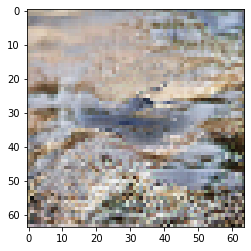

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 19

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.090356826782227 sec
Gen loss: 3.8750820896489833, Disc loss: 0.5548510385076528
Time for epoch 2 is 13.066814184188843 sec
Gen loss: 3.8541184318097947, Disc loss: 0.5529771964886001
Time for epoch 3 is 13.070359230041504 sec
Gen loss: 3.887876206297215, Disc loss: 0.5541996909027823
Time for epoch 4 is 13.1013925075531 sec
Gen loss: 3.831312788857354, Disc loss: 0.55494357350719
Time for epoch 5 is 13.086715459823608 sec
Gen loss: 3.7802337598671434, Disc loss: 0.5642493365579827
Time for epoch 6 is 13.090352535247803 sec
Gen loss: 3.8013056771865057, Disc loss: 0.5579786717407103
Time for epoch 7 is 13.087275981903076 sec
Gen loss: 3.8582399091746424, Disc loss: 0.5576310339497357
Time for epoch 8 is 13.108054399490356 sec
Gen loss: 3.8577354833039488, Disc loss: 0.5559405508403209
Time for epoch 9 is 13.140643835067749 sec
Gen loss: 3.7954965109

Time for epoch 80 is 13.068213701248169 sec
Gen loss: 3.855563061670236, Disc loss: 0.5499152542775886
Time for epoch 81 is 13.091721534729004 sec
Gen loss: 3.8331728110791543, Disc loss: 0.5596579153363298
Time for epoch 82 is 13.083789110183716 sec
Gen loss: 3.84729714122245, Disc loss: 0.5565928884638034
Time for epoch 83 is 13.170158386230469 sec
Gen loss: 3.8345415146370243, Disc loss: 0.5526569149681546
Time for epoch 84 is 13.090706825256348 sec
Gen loss: 3.8633934676162593, Disc loss: 0.5565057682797192
Time for epoch 85 is 13.068082332611084 sec
Gen loss: 3.8466823624401556, Disc loss: 0.5513139185382099
Time for epoch 86 is 13.067997694015503 sec
Gen loss: 3.7853480793919343, Disc loss: 0.5599008633030785
Time for epoch 87 is 13.069574117660522 sec
Gen loss: 3.8314410257468703, Disc loss: 0.5587070638409798
Time for epoch 88 is 13.118380546569824 sec
Gen loss: 3.9841896008023725, Disc loss: 0.5531318060104763
Time for epoch 89 is 13.083035469055176 sec
Gen loss: 3.81679707620

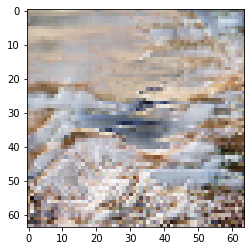

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.135300397872925 sec
Gen loss: 3.830653801196959, Disc loss: 0.5542062336028752
Time for epoch 2 is 13.07873797416687 sec
Gen loss: 3.83620359322566, Disc loss: 0.5605332903907227
Time for epoch 3 is 13.07160496711731 sec
Gen loss: 3.7497452765622437, Disc loss: 0.5635691173677522
Time for epoch 4 is 13.106005907058716 sec
Gen loss: 3.8733024338719644, Disc loss: 0.5502852680398843
Time for epoch 5 is 13.111480712890625 sec
Gen loss: 3.85465750913956, Disc loss: 0.5530377156366177
Time for epoch 6 is 13.107742547988892 sec
Gen loss: 3.855116167042637, Disc loss: 0.560931672329502
Time for epoch 7 is 13.109705209732056 sec
Gen loss: 3.8165780367243904, Disc loss: 0.5598520034858527
Time for epoch 8 is 13.086087942123413 sec
Gen loss: 3.813070204199814, Disc loss: 0.55588764549917
Time for epoch 9 is 13.095338344573975 sec
Gen loss: 3.8078259963007155

Time for epoch 80 is 13.093895673751831 sec
Gen loss: 3.8293671485208236, Disc loss: 0.5633200819737866
Time for epoch 81 is 13.095924615859985 sec
Gen loss: 3.784662752616696, Disc loss: 0.5610738974922718
Time for epoch 82 is 13.08384394645691 sec
Gen loss: 3.803637831514767, Disc loss: 0.5569411159207828
Time for epoch 83 is 13.193817615509033 sec
Gen loss: 3.754036039517824, Disc loss: 0.5669877433033816
Time for epoch 84 is 13.110049962997437 sec
Gen loss: 3.803337259990413, Disc loss: 0.5574689538982825
Time for epoch 85 is 13.08578896522522 sec
Gen loss: 3.8984417928266653, Disc loss: 0.550665005031963
Time for epoch 86 is 13.105132102966309 sec
Gen loss: 3.7769882246084654, Disc loss: 0.5701849364491336
Time for epoch 87 is 13.099033832550049 sec
Gen loss: 3.786456902821859, Disc loss: 0.5604118269471942
Time for epoch 88 is 13.07989501953125 sec
Gen loss: 3.94522430709384, Disc loss: 0.5466877530583845
Time for epoch 89 is 13.09180212020874 sec
Gen loss: 3.8321971285956984, Di

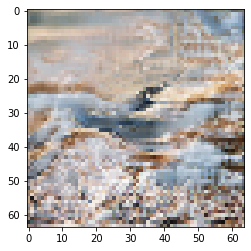

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 21

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.100549459457397 sec
Gen loss: 3.791127151913113, Disc loss: 0.5583365341512169
Time for epoch 2 is 13.12201714515686 sec
Gen loss: 3.879210790644493, Disc loss: 0.5510078779242549
Time for epoch 3 is 13.086466789245605 sec
Gen loss: 3.972917342896707, Disc loss: 0.555163478544411
Time for epoch 4 is 13.116693496704102 sec
Gen loss: 3.8029879347741766, Disc loss: 0.559924039818084
Time for epoch 5 is 13.099800825119019 sec
Gen loss: 3.8009087276975637, Disc loss: 0.5594751867175425
Time for epoch 6 is 13.103678703308105 sec
Gen loss: 3.875672690590546, Disc loss: 0.556697597267828
Time for epoch 7 is 13.10308837890625 sec
Gen loss: 3.8264678694045315, Disc loss: 0.5590687398180406
Time for epoch 8 is 13.129497528076172 sec
Gen loss: 3.8329465098497346, Disc loss: 0.5517116368301516
Time for epoch 9 is 13.09186577796936 sec
Gen loss: 3.84554306019935

Time for epoch 80 is 13.098912477493286 sec
Gen loss: 3.823930631808149, Disc loss: 0.5628798418251802
Time for epoch 81 is 13.110002994537354 sec
Gen loss: 3.789599060689208, Disc loss: 0.5593769241800799
Time for epoch 82 is 13.05972671508789 sec
Gen loss: 3.7500286464122574, Disc loss: 0.5643392449956599
Time for epoch 83 is 13.104475498199463 sec
Gen loss: 3.802213847798707, Disc loss: 0.5592142159376687
Time for epoch 84 is 13.191223859786987 sec
Gen loss: 3.8079487353482544, Disc loss: 0.5679827321189529
Time for epoch 85 is 13.079484701156616 sec
Gen loss: 3.7885929136095333, Disc loss: 0.560340733628286
Time for epoch 86 is 13.094526529312134 sec
Gen loss: 3.8122866987212887, Disc loss: 0.5597166083046414
Time for epoch 87 is 13.122750997543335 sec
Gen loss: 3.772337000544478, Disc loss: 0.5648827885547627
Time for epoch 88 is 13.10135555267334 sec
Gen loss: 3.8543245055811193, Disc loss: 0.5494526800747487
Time for epoch 89 is 13.090187549591064 sec
Gen loss: 3.838664350147815

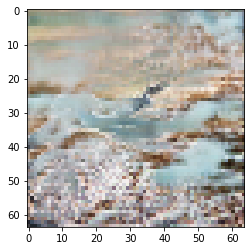

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 22

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.081408739089966 sec
Gen loss: 3.7772875704416413, Disc loss: 0.5631618002242835
Time for epoch 2 is 13.208829641342163 sec
Gen loss: 3.7272544811734662, Disc loss: 0.5630822041170384
Time for epoch 3 is 13.118008136749268 sec
Gen loss: 3.839750369389852, Disc loss: 0.5575220138238375
Time for epoch 4 is 13.095443964004517 sec
Gen loss: 3.7672247007933413, Disc loss: 0.5643111644237022
Time for epoch 5 is 13.11046552658081 sec
Gen loss: 3.8709098853392976, Disc loss: 0.5558349742960478
Time for epoch 6 is 13.093149423599243 sec
Gen loss: 3.8584572435394535, Disc loss: 0.5607224689912667
Time for epoch 7 is 13.138977289199829 sec
Gen loss: 3.769046172216979, Disc loss: 0.5635080473209785
Time for epoch 8 is 13.059046506881714 sec
Gen loss: 3.7836460220781447, Disc loss: 0.5635537521302861
Time for epoch 9 is 13.09664011001587 sec
Gen loss: 3.83545305

Time for epoch 80 is 13.115065813064575 sec
Gen loss: 3.7655718552710886, Disc loss: 0.5632411315835265
Time for epoch 81 is 13.129529237747192 sec
Gen loss: 3.852849051235168, Disc loss: 0.5583696944442221
Time for epoch 82 is 13.08186650276184 sec
Gen loss: 3.779962110648633, Disc loss: 0.5645632573421085
Time for epoch 83 is 13.087543249130249 sec
Gen loss: 3.737059516958428, Disc loss: 0.5661895920429126
Time for epoch 84 is 13.163130521774292 sec
Gen loss: 3.82469112052504, Disc loss: 0.5563189657884562
Time for epoch 85 is 13.123272180557251 sec
Gen loss: 3.7481314715977283, Disc loss: 0.5644972149918719
Time for epoch 86 is 13.08444619178772 sec
Gen loss: 3.8247162669008663, Disc loss: 0.5637396191193805
Time for epoch 87 is 13.078675746917725 sec
Gen loss: 3.79344245218003, Disc loss: 0.5678922201236736
Time for epoch 88 is 13.064106941223145 sec
Gen loss: 3.7662799681428325, Disc loss: 0.5678931239659224
Time for epoch 89 is 13.10191011428833 sec
Gen loss: 3.7543376073604677, 

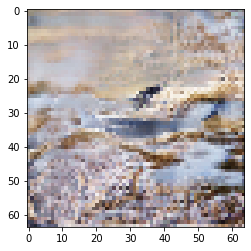

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 23

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.068158149719238 sec
Gen loss: 3.7890237695802518, Disc loss: 0.5673961324420401
Time for epoch 2 is 13.062221765518188 sec
Gen loss: 3.732548747928485, Disc loss: 0.5661164216071286
Time for epoch 3 is 13.125996351242065 sec
Gen loss: 3.767137838896051, Disc loss: 0.5644679185013138
Time for epoch 4 is 13.08409857749939 sec
Gen loss: 3.8151431064295576, Disc loss: 0.5584638394960543
Time for epoch 5 is 13.081830024719238 sec
Gen loss: 3.792821090718918, Disc loss: 0.5688476589960134
Time for epoch 6 is 13.12467098236084 sec
Gen loss: 3.747208482850858, Disc loss: 0.5702192703398262
Time for epoch 7 is 13.090738534927368 sec
Gen loss: 3.716576517435916, Disc loss: 0.5647726737386812
Time for epoch 8 is 13.065063714981079 sec
Gen loss: 3.806559839868933, Disc loss: 0.5633905235183271
Time for epoch 9 is 13.110275030136108 sec
Gen loss: 3.763097123401

Time for epoch 80 is 13.08555555343628 sec
Gen loss: 3.8084034809898233, Disc loss: 0.5603039591777615
Time for epoch 81 is 13.161132335662842 sec
Gen loss: 3.805099027912791, Disc loss: 0.5627885787952237
Time for epoch 82 is 13.113093614578247 sec
Gen loss: 3.72641870839809, Disc loss: 0.5702088640795814
Time for epoch 83 is 13.087837219238281 sec
Gen loss: 3.751763426514499, Disc loss: 0.5657534256052519
Time for epoch 84 is 13.08369779586792 sec
Gen loss: 3.797279757858938, Disc loss: 0.561730540218715
Time for epoch 85 is 13.129195213317871 sec
Gen loss: 3.745876511261069, Disc loss: 0.5662180831438803
Time for epoch 86 is 13.105309009552002 sec
Gen loss: 3.791586536702102, Disc loss: 0.5660597540660279
Time for epoch 87 is 13.079166173934937 sec
Gen loss: 3.831791147630066, Disc loss: 0.5558818723289625
Time for epoch 88 is 13.100929021835327 sec
Gen loss: 3.7379881644313575, Disc loss: 0.5631282116339459
Time for epoch 89 is 13.066569805145264 sec
Gen loss: 3.7805896567781443, D

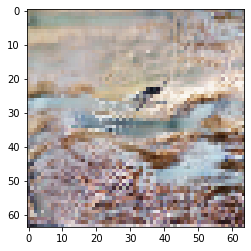

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 24

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.117989301681519 sec
Gen loss: 3.7859167361324073, Disc loss: 0.5659757136167872
Time for epoch 2 is 13.085885763168335 sec
Gen loss: 3.796054436262384, Disc loss: 0.5601032556395543
Time for epoch 3 is 13.152894735336304 sec
Gen loss: 3.7643329224935393, Disc loss: 0.569711180560311
Time for epoch 4 is 13.147590637207031 sec
Gen loss: 3.7346750959794375, Disc loss: 0.5668532392842983
Time for epoch 5 is 13.102519750595093 sec
Gen loss: 3.7791273736049167, Disc loss: 0.5616950761011945
Time for epoch 6 is 13.087824821472168 sec
Gen loss: 3.776989286184957, Disc loss: 0.567550061679468
Time for epoch 7 is 13.083150863647461 sec
Gen loss: 3.71273313111406, Disc loss: 0.5643053148497088
Time for epoch 8 is 13.07411503791809 sec
Gen loss: 3.874062274529682, Disc loss: 0.5609612556977001
Time for epoch 9 is 13.066685676574707 sec
Gen loss: 3.718299549769

Time for epoch 80 is 13.105453491210938 sec
Gen loss: 3.7044678503258766, Disc loss: 0.5714025912569144
Time for epoch 81 is 13.11464238166809 sec
Gen loss: 3.7185694066489616, Disc loss: 0.5669019249719656
Time for epoch 82 is 13.126966714859009 sec
Gen loss: 3.8010399729255737, Disc loss: 0.5610008612880862
Time for epoch 83 is 13.103780746459961 sec
Gen loss: 3.7592110879376004, Disc loss: 0.5648599225008067
Time for epoch 84 is 13.063791036605835 sec
Gen loss: 3.7973816724327523, Disc loss: 0.5670367959876693
Time for epoch 85 is 13.107994079589844 sec
Gen loss: 3.7815193225374713, Disc loss: 0.566831138964268
Time for epoch 86 is 13.15744161605835 sec
Gen loss: 3.7726748215796824, Disc loss: 0.5660547768358939
Time for epoch 87 is 13.11653733253479 sec
Gen loss: 3.797431507084751, Disc loss: 0.5637277151510968
Time for epoch 88 is 13.091775894165039 sec
Gen loss: 3.741027200771218, Disc loss: 0.5718432576029604
Time for epoch 89 is 13.118964910507202 sec
Gen loss: 3.68920266919019

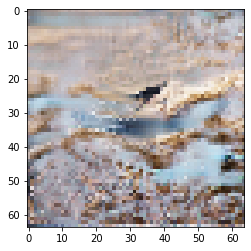

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 25

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.069576740264893 sec
Gen loss: 3.785200793568681, Disc loss: 0.5638813184205755
Time for epoch 2 is 13.082041025161743 sec
Gen loss: 3.8091620119606575, Disc loss: 0.5653952390843937
Time for epoch 3 is 13.087487936019897 sec
Gen loss: 3.722400318962449, Disc loss: 0.5734314189209202
Time for epoch 4 is 13.070905447006226 sec
Gen loss: 3.7458330467141416, Disc loss: 0.5719487781770184
Time for epoch 5 is 13.221380472183228 sec
Gen loss: 3.723687626158965, Disc loss: 0.5686264780317218
Time for epoch 6 is 13.117920875549316 sec
Gen loss: 3.7589001235600086, Disc loss: 0.5642441595957531
Time for epoch 7 is 13.095511198043823 sec
Gen loss: 3.8915371694538976, Disc loss: 0.5596762043512288
Time for epoch 8 is 13.081631660461426 sec
Gen loss: 3.7666099653011416, Disc loss: 0.5634348778543756
Time for epoch 9 is 13.094706773757935 sec
Gen loss: 3.7991839

Time for epoch 80 is 13.07303500175476 sec
Gen loss: 3.7376988993750677, Disc loss: 0.569692437160952
Time for epoch 81 is 13.072310209274292 sec
Gen loss: 3.869217732411413, Disc loss: 0.5605861084247993
Time for epoch 82 is 13.057995796203613 sec
Gen loss: 3.703737245342596, Disc loss: 0.5751970392578662
Time for epoch 83 is 13.09359097480774 sec
Gen loss: 3.686087130854123, Disc loss: 0.5722721744843615
Time for epoch 84 is 13.098598718643188 sec
Gen loss: 3.6838276017972125, Disc loss: 0.5710823518958518
Time for epoch 85 is 13.071811437606812 sec
Gen loss: 3.808463814458873, Disc loss: 0.5675471731156192
Time for epoch 86 is 13.075389385223389 sec
Gen loss: 3.7067436241522067, Disc loss: 0.5724261514539641
Time for epoch 87 is 13.147847414016724 sec
Gen loss: 3.738937805015543, Disc loss: 0.573254612080127
Time for epoch 88 is 13.092019081115723 sec
Gen loss: 3.685043374374307, Disc loss: 0.5751927147712811
Time for epoch 89 is 13.120269298553467 sec
Gen loss: 3.746641230777027, D

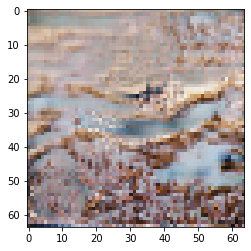

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 26

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.127697229385376 sec
Gen loss: 3.773341236398795, Disc loss: 0.5613456259413463
Time for epoch 2 is 13.126675128936768 sec
Gen loss: 3.7408224347484142, Disc loss: 0.5732552891339713
Time for epoch 3 is 13.087852239608765 sec
Gen loss: 3.7039774239547856, Disc loss: 0.5790353696036145
Time for epoch 4 is 13.089636087417603 sec
Gen loss: 3.7094909130396236, Disc loss: 0.5768107797718307
Time for epoch 5 is 13.129494428634644 sec
Gen loss: 3.7707551824368113, Disc loss: 0.5650436341924073
Time for epoch 6 is 13.114453792572021 sec
Gen loss: 3.7357499089021347, Disc loss: 0.5736077721849043
Time for epoch 7 is 13.068679094314575 sec
Gen loss: 3.735810851663109, Disc loss: 0.571684636720797
Time for epoch 8 is 13.099721670150757 sec
Gen loss: 3.7150715004783983, Disc loss: 0.5813770588982073
Time for epoch 9 is 13.093998432159424 sec
Gen loss: 3.6850555

Time for epoch 80 is 13.090263605117798 sec
Gen loss: 3.6652672213267503, Disc loss: 0.5841834301224892
Time for epoch 81 is 13.101977586746216 sec
Gen loss: 3.7009502833451684, Disc loss: 0.5792582295935974
Time for epoch 82 is 13.085285663604736 sec
Gen loss: 3.6063630626130556, Disc loss: 0.5857178152899755
Time for epoch 83 is 13.124030113220215 sec
Gen loss: 3.61730979322418, Disc loss: 0.592474299071604
Time for epoch 84 is 13.079549312591553 sec
Gen loss: 3.644523371202836, Disc loss: 0.5860356442973542
Time for epoch 85 is 13.096087455749512 sec
Gen loss: 3.630469069571353, Disc loss: 0.5888918026029902
Time for epoch 86 is 13.063663959503174 sec
Gen loss: 3.6180590685144027, Disc loss: 0.5859697514433202
Time for epoch 87 is 13.065537691116333 sec
Gen loss: 3.6362469958742136, Disc loss: 0.5852528468864721
Time for epoch 88 is 13.129534721374512 sec
Gen loss: 3.653224437863523, Disc loss: 0.583211817554019
Time for epoch 89 is 13.08567214012146 sec
Gen loss: 3.594221131911446,

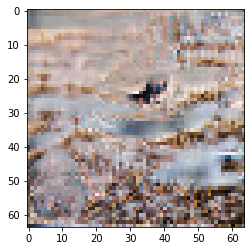

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 27

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.125411033630371 sec
Gen loss: 3.634722977149777, Disc loss: 0.5836716056839237
Time for epoch 2 is 13.120885133743286 sec
Gen loss: 3.691930363817913, Disc loss: 0.5765039150307818
Time for epoch 3 is 13.113774299621582 sec
Gen loss: 3.637627335421761, Disc loss: 0.5833654492528135
Time for epoch 4 is 13.09275221824646 sec
Gen loss: 3.618507816216487, Disc loss: 0.5904851012275147
Time for epoch 5 is 13.098281860351562 sec
Gen loss: 3.734887685879136, Disc loss: 0.5768700859087915
Time for epoch 6 is 13.121957063674927 sec
Gen loss: 3.628027486284251, Disc loss: 0.5879524077180278
Time for epoch 7 is 13.092934370040894 sec
Gen loss: 3.6060726300164614, Disc loss: 0.5890714619056319
Time for epoch 8 is 13.10917353630066 sec
Gen loss: 3.680930248120936, Disc loss: 0.5823343524603339
Time for epoch 9 is 13.096054315567017 sec
Gen loss: 3.6521343545215

Time for epoch 80 is 13.124095678329468 sec
Gen loss: 3.617400825831302, Disc loss: 0.5924618363703492
Time for epoch 81 is 13.109110593795776 sec
Gen loss: 3.5931637248372645, Disc loss: 0.5975223802292573
Time for epoch 82 is 13.119255781173706 sec
Gen loss: 3.6149016163213465, Disc loss: 0.591056174298289
Time for epoch 83 is 13.105787992477417 sec
Gen loss: 3.630925373010196, Disc loss: 0.5833519492045973
Time for epoch 84 is 13.106055498123169 sec
Gen loss: 3.6408197970248173, Disc loss: 0.5851083378481671
Time for epoch 85 is 13.108355045318604 sec
Gen loss: 3.6304370930524374, Disc loss: 0.5861226586791558
Time for epoch 86 is 13.11666989326477 sec
Gen loss: 3.614066819834515, Disc loss: 0.5909140185935065
Time for epoch 87 is 13.060407876968384 sec
Gen loss: 3.6036735330493794, Disc loss: 0.5923747467154733
Time for epoch 88 is 13.111726522445679 sec
Gen loss: 3.603574238495452, Disc loss: 0.5867946532360584
Time for epoch 89 is 13.12490963935852 sec
Gen loss: 3.644261726518956

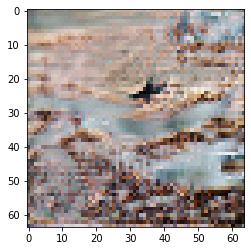

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 28

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.086089134216309 sec
Gen loss: 3.632254707134836, Disc loss: 0.5876543757715199
Time for epoch 2 is 13.082246780395508 sec
Gen loss: 3.5899678769150403, Disc loss: 0.5896239510881223
Time for epoch 3 is 13.099200248718262 sec
Gen loss: 3.628187982693597, Disc loss: 0.5881047743930403
Time for epoch 4 is 13.085456609725952 sec
Gen loss: 3.6321873089808436, Disc loss: 0.5831817826281395
Time for epoch 5 is 13.099547863006592 sec
Gen loss: 3.605096685854077, Disc loss: 0.5876484800806536
Time for epoch 6 is 13.077130317687988 sec
Gen loss: 3.6425557007311484, Disc loss: 0.5879804750445089
Time for epoch 7 is 13.184285879135132 sec
Gen loss: 3.589220215634602, Disc loss: 0.5918019338028864
Time for epoch 8 is 13.104024410247803 sec
Gen loss: 3.624665674478381, Disc loss: 0.5883782865393775
Time for epoch 9 is 13.09433913230896 sec
Gen loss: 3.6222405407

Time for epoch 80 is 13.18420672416687 sec
Gen loss: 3.57398255666097, Disc loss: 0.5968886197905553
Time for epoch 81 is 13.100987672805786 sec
Gen loss: 3.587682151535985, Disc loss: 0.591752072336874
Time for epoch 82 is 13.09479284286499 sec
Gen loss: 3.580811689216593, Disc loss: 0.5897224062503514
Time for epoch 83 is 13.073858976364136 sec
Gen loss: 3.5725533354896193, Disc loss: 0.5922032394383335
Time for epoch 84 is 13.107845067977905 sec
Gen loss: 3.570612886087681, Disc loss: 0.5956714191249393
Time for epoch 85 is 13.097624063491821 sec
Gen loss: 3.6134103184469994, Disc loss: 0.5903772419384179
Time for epoch 86 is 13.066254377365112 sec
Gen loss: 3.602598318239538, Disc loss: 0.5917515767622124
Time for epoch 87 is 13.083320140838623 sec
Gen loss: 3.575124573255296, Disc loss: 0.5932152699325789
Time for epoch 88 is 13.093877792358398 sec
Gen loss: 3.6862262658633513, Disc loss: 0.5832760158754623
Time for epoch 89 is 13.118019342422485 sec
Gen loss: 3.5647441791648142, 

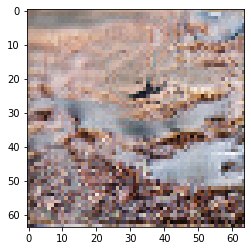

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 29

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.10857605934143 sec
Gen loss: 3.630726075107812, Disc loss: 0.5837921615700089
Time for epoch 2 is 13.05629014968872 sec
Gen loss: 3.5737670282038247, Disc loss: 0.5950477430975534
Time for epoch 3 is 13.123610734939575 sec
Gen loss: 3.590118330022507, Disc loss: 0.5904528402539126
Time for epoch 4 is 13.080040693283081 sec
Gen loss: 3.5704785291418473, Disc loss: 0.5972682149591162
Time for epoch 5 is 13.069326877593994 sec
Gen loss: 3.615376535146863, Disc loss: 0.5868722988661066
Time for epoch 6 is 13.096898317337036 sec
Gen loss: 3.6509548286758466, Disc loss: 0.5878645592750249
Time for epoch 7 is 13.083173751831055 sec
Gen loss: 3.6438194723310184, Disc loss: 0.5864311948539765
Time for epoch 8 is 13.15894865989685 sec
Gen loss: 3.644357343999351, Disc loss: 0.5876151375815797
Time for epoch 9 is 13.111524820327759 sec
Gen loss: 3.59133723176

Time for epoch 80 is 13.06118655204773 sec
Gen loss: 3.614344555511061, Disc loss: 0.5933957032071866
Time for epoch 81 is 13.130300045013428 sec
Gen loss: 3.589809268470702, Disc loss: 0.5971969735977772
Time for epoch 82 is 13.102280378341675 sec
Gen loss: 3.6286844826003075, Disc loss: 0.5896587688425369
Time for epoch 83 is 13.137223243713379 sec
Gen loss: 3.5628443546088406, Disc loss: 0.5956329910089653
Time for epoch 84 is 13.06396222114563 sec
Gen loss: 3.686449662779728, Disc loss: 0.5838264606509428
Time for epoch 85 is 13.091408491134644 sec
Gen loss: 3.5934831721349783, Disc loss: 0.5924382213816087
Time for epoch 86 is 13.10282588005066 sec
Gen loss: 3.5942817742262427, Disc loss: 0.5885648777491355
Time for epoch 87 is 13.07809042930603 sec
Gen loss: 3.633595980279814, Disc loss: 0.5839453150586384
Time for epoch 88 is 13.067232370376587 sec
Gen loss: 3.535209838613908, Disc loss: 0.6002320767579686
Time for epoch 89 is 13.10392951965332 sec
Gen loss: 3.655098513859074, D

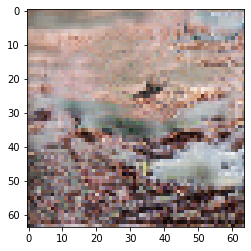

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 30

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.07159972190857 sec
Gen loss: 3.5506713202975306, Disc loss: 0.598571374002834
Time for epoch 2 is 13.104629516601562 sec
Gen loss: 3.6120229671964155, Disc loss: 0.5923790722520048
Time for epoch 3 is 13.071815252304077 sec
Gen loss: 3.5636066744321084, Disc loss: 0.5927620227259349
Time for epoch 4 is 13.110592126846313 sec
Gen loss: 3.559859890278762, Disc loss: 0.5962310254896882
Time for epoch 5 is 13.104763984680176 sec
Gen loss: 3.5578680148292685, Disc loss: 0.5963292898847482
Time for epoch 6 is 13.101218223571777 sec
Gen loss: 3.6249194998082106, Disc loss: 0.5883184528447748
Time for epoch 7 is 13.130656242370605 sec
Gen loss: 3.6614862864579614, Disc loss: 0.5802411346577694
Time for epoch 8 is 13.103596210479736 sec
Gen loss: 3.610757807082923, Disc loss: 0.5920597140381976
Time for epoch 9 is 13.111782312393188 sec
Gen loss: 3.61084495

Time for epoch 80 is 13.101969242095947 sec
Gen loss: 3.6488775838681353, Disc loss: 0.5849434432136981
Time for epoch 81 is 13.061627626419067 sec
Gen loss: 3.5482197641357174, Disc loss: 0.5931113641759568
Time for epoch 82 is 13.145197868347168 sec
Gen loss: 3.582395263480623, Disc loss: 0.5933536049634783
Time for epoch 83 is 13.074918746948242 sec
Gen loss: 3.6044297425081413, Disc loss: 0.5936154326610772
Time for epoch 84 is 13.077807903289795 sec
Gen loss: 3.5276238401407793, Disc loss: 0.5991066090944337
Time for epoch 85 is 13.094885110855103 sec
Gen loss: 3.5756177133337914, Disc loss: 0.5913548593921714
Time for epoch 86 is 13.09900712966919 sec
Gen loss: 3.5515759475832063, Disc loss: 0.5943862725564135
Time for epoch 87 is 13.091385126113892 sec
Gen loss: 3.5441085917516775, Disc loss: 0.5934710914526529
Time for epoch 88 is 13.103527784347534 sec
Gen loss: 3.6241904984967817, Disc loss: 0.5907029954560081
Time for epoch 89 is 13.093536376953125 sec
Gen loss: 3.5370539171

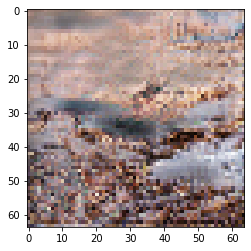

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 31

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.073879718780518 sec
Gen loss: 3.5616601418027387, Disc loss: 0.5954378517016485
Time for epoch 2 is 13.05639362335205 sec
Gen loss: 3.633266661548356, Disc loss: 0.5904606239905525
Time for epoch 3 is 13.137193202972412 sec
Gen loss: 3.579251131068077, Disc loss: 0.5911612906430149
Time for epoch 4 is 13.1096351146698 sec
Gen loss: 3.552979071935018, Disc loss: 0.5959441477690286
Time for epoch 5 is 13.128395557403564 sec
Gen loss: 3.540286245707897, Disc loss: 0.5999917475996301
Time for epoch 6 is 13.100146055221558 sec
Gen loss: 3.534176095068293, Disc loss: 0.5997011824675046
Time for epoch 7 is 13.074431657791138 sec
Gen loss: 3.6015079150678018, Disc loss: 0.5917471163479616
Time for epoch 8 is 13.066058158874512 sec
Gen loss: 3.6262128837709504, Disc loss: 0.5886304628881336
Time for epoch 9 is 13.146188259124756 sec
Gen loss: 3.527621201383

Time for epoch 80 is 13.076863288879395 sec
Gen loss: 3.6037772574075837, Disc loss: 0.5907274961148498
Time for epoch 81 is 13.199756622314453 sec
Gen loss: 3.6252735481675726, Disc loss: 0.5905582083434593
Time for epoch 82 is 13.20472764968872 sec
Gen loss: 3.5353842020680912, Disc loss: 0.5999677042327922
Time for epoch 83 is 13.246906280517578 sec
Gen loss: 3.5058171626352035, Disc loss: 0.5985042480272329
Time for epoch 84 is 13.17300009727478 sec
Gen loss: 3.565379451606978, Disc loss: 0.599453234333333
Time for epoch 85 is 13.122481346130371 sec
Gen loss: 3.5281138542867936, Disc loss: 0.5965626041902113
Time for epoch 86 is 13.123460531234741 sec
Gen loss: 3.5350230386263632, Disc loss: 0.5948046203551254
Time for epoch 87 is 13.124984741210938 sec
Gen loss: 3.5652067137927546, Disc loss: 0.5961327351690308
Time for epoch 88 is 13.14521312713623 sec
Gen loss: 3.5319207748423422, Disc loss: 0.5976070693030267
Time for epoch 89 is 13.148886919021606 sec
Gen loss: 3.5350260657023

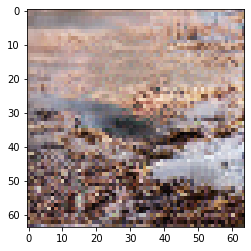

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 32

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.129707098007202 sec
Gen loss: 3.5836177195313823, Disc loss: 0.5973190886541434
Time for epoch 2 is 13.105542659759521 sec
Gen loss: 3.5485630487684956, Disc loss: 0.5945389077753879
Time for epoch 3 is 13.108405590057373 sec
Gen loss: 3.501921346194053, Disc loss: 0.6021717823940888
Time for epoch 4 is 13.116629838943481 sec
Gen loss: 3.6074044232769062, Disc loss: 0.5907187183213428
Time for epoch 5 is 13.075785875320435 sec
Gen loss: 3.5013946214019445, Disc loss: 0.6035433077230686
Time for epoch 6 is 13.075175762176514 sec
Gen loss: 3.6681586720433015, Disc loss: 0.5863025219944434
Time for epoch 7 is 13.072713136672974 sec
Gen loss: 3.5048432518150103, Disc loss: 0.6014580389833063
Time for epoch 8 is 13.121336698532104 sec
Gen loss: 3.5614419791110485, Disc loss: 0.590943508274187
Time for epoch 9 is 13.094306707382202 sec
Gen loss: 3.531570

Time for epoch 80 is 13.096222877502441 sec
Gen loss: 3.5267135954807767, Disc loss: 0.5999062744582572
Time for epoch 81 is 13.093577146530151 sec
Gen loss: 3.539267861746191, Disc loss: 0.5964165636840552
Time for epoch 82 is 13.098741292953491 sec
Gen loss: 3.4966850500442797, Disc loss: 0.6019428025900833
Time for epoch 83 is 13.152122974395752 sec
Gen loss: 3.5727754679475696, Disc loss: 0.5901794947259794
Time for epoch 84 is 13.107598781585693 sec
Gen loss: 3.5512201734351594, Disc loss: 0.599575185921134
Time for epoch 85 is 13.054096221923828 sec
Gen loss: 3.582025524077377, Disc loss: 0.5924355785051981
Time for epoch 86 is 13.056095600128174 sec
Gen loss: 3.592171146294612, Disc loss: 0.5939522334715215
Time for epoch 87 is 13.098033666610718 sec
Gen loss: 3.5683965670060984, Disc loss: 0.5927223181982997
Time for epoch 88 is 13.08299469947815 sec
Gen loss: 3.557163888522926, Disc loss: 0.5970207452774048
Time for epoch 89 is 13.101423740386963 sec
Gen loss: 3.59469454269099

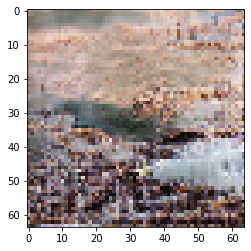

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 33

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.12715482711792 sec
Gen loss: 3.5278158795219774, Disc loss: 0.5985035794537242
Time for epoch 2 is 13.171715259552002 sec
Gen loss: 3.5529393490737045, Disc loss: 0.5979463550941084
Time for epoch 3 is 13.068273305892944 sec
Gen loss: 3.5385617492644768, Disc loss: 0.5982981423536936
Time for epoch 4 is 13.096085786819458 sec
Gen loss: 3.55094150217568, Disc loss: 0.5967302687445953
Time for epoch 5 is 13.116971015930176 sec
Gen loss: 3.582891504292889, Disc loss: 0.5954707304475108
Time for epoch 6 is 13.087783336639404 sec
Gen loss: 3.5380667800179664, Disc loss: 0.6023541841565109
Time for epoch 7 is 13.067930698394775 sec
Gen loss: 3.5538786775697537, Disc loss: 0.5946228191619967
Time for epoch 8 is 13.07236361503601 sec
Gen loss: 3.543882102501102, Disc loss: 0.6000061458365381
Time for epoch 9 is 13.106789588928223 sec
Gen loss: 3.5178362657

Time for epoch 80 is 13.106128931045532 sec
Gen loss: 3.5205259452344277, Disc loss: 0.6019207594517447
Time for epoch 81 is 13.088602542877197 sec
Gen loss: 3.5765951480968856, Disc loss: 0.5944439061288911
Time for epoch 82 is 13.088274002075195 sec
Gen loss: 3.583607487562226, Disc loss: 0.5922787989865796
Time for epoch 83 is 13.112797498703003 sec
Gen loss: 3.523729676476662, Disc loss: 0.6010001377684637
Time for epoch 84 is 13.137913465499878 sec
Gen loss: 3.540053547882452, Disc loss: 0.6019047083570382
Time for epoch 85 is 13.096448421478271 sec
Gen loss: 3.5600639714135065, Disc loss: 0.5923261850022365
Time for epoch 86 is 13.07439136505127 sec
Gen loss: 3.500252317283858, Disc loss: 0.6014475392778391
Time for epoch 87 is 13.09337854385376 sec
Gen loss: 3.652986636329796, Disc loss: 0.5928564616819707
Time for epoch 88 is 13.091862916946411 sec
Gen loss: 3.5516524030587213, Disc loss: 0.5949803407437756
Time for epoch 89 is 13.10393476486206 sec
Gen loss: 3.5112441348512644

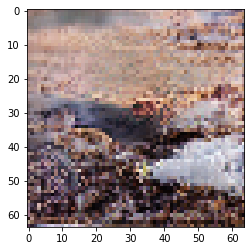

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 34

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.107488632202148 sec
Gen loss: 3.5545387448980232, Disc loss: 0.5974862174128452
Time for epoch 2 is 13.109321355819702 sec
Gen loss: 3.557787083674899, Disc loss: 0.5995357640713534
Time for epoch 3 is 13.110850811004639 sec
Gen loss: 3.5625430309998634, Disc loss: 0.595724846370175
Time for epoch 4 is 13.091568946838379 sec
Gen loss: 3.5200500029535475, Disc loss: 0.6019010124652366
Time for epoch 5 is 13.096613645553589 sec
Gen loss: 3.5778676462044237, Disc loss: 0.5977369817453348
Time for epoch 6 is 13.081989526748657 sec
Gen loss: 3.5392128103147678, Disc loss: 0.6031142174389951
Time for epoch 7 is 13.09348726272583 sec
Gen loss: 3.5759953935618, Disc loss: 0.590707145166914
Time for epoch 8 is 13.140564441680908 sec
Gen loss: 3.5645868584392515, Disc loss: 0.5973728901648586
Time for epoch 9 is 13.0811288356781 sec
Gen loss: 3.4994721438503

Time for epoch 80 is 13.063563823699951 sec
Gen loss: 3.5744900490210307, Disc loss: 0.5950067299329814
Time for epoch 81 is 13.08101749420166 sec
Gen loss: 3.5855271641801045, Disc loss: 0.59574864429187
Time for epoch 82 is 13.11785364151001 sec
Gen loss: 3.5252294921616554, Disc loss: 0.6005548187064608
Time for epoch 83 is 13.081863164901733 sec
Gen loss: 3.591023753975142, Disc loss: 0.5932177392447867
Time for epoch 84 is 13.143950939178467 sec
Gen loss: 3.580565745268411, Disc loss: 0.5957868538574798
Time for epoch 85 is 13.153752565383911 sec
Gen loss: 3.524835653098295, Disc loss: 0.5986339655025865
Time for epoch 86 is 13.158557176589966 sec
Gen loss: 3.590957753380463, Disc loss: 0.5949215337351409
Time for epoch 87 is 13.089800834655762 sec
Gen loss: 3.4963034252487226, Disc loss: 0.6010178648197877
Time for epoch 88 is 13.07464051246643 sec
Gen loss: 3.636146832287796, Disc loss: 0.5888797912171216
Time for epoch 89 is 13.093876600265503 sec
Gen loss: 3.581240891118037, D

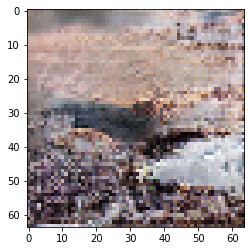

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 35

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.069948196411133 sec
Gen loss: 3.5933495375522106, Disc loss: 0.5939058722034702
Time for epoch 2 is 13.139052391052246 sec
Gen loss: 3.5101734622707212, Disc loss: 0.6001807678198103
Time for epoch 3 is 13.138205528259277 sec
Gen loss: 3.536712862288726, Disc loss: 0.5999174488753807
Time for epoch 4 is 13.097518682479858 sec
Gen loss: 3.5373007882901324, Disc loss: 0.6030765515840474
Time for epoch 5 is 13.120856046676636 sec
Gen loss: 3.532920505942368, Disc loss: 0.5972168595810247
Time for epoch 6 is 13.07363748550415 sec
Gen loss: 3.525201936401326, Disc loss: 0.6008546434766878
Time for epoch 7 is 13.070400476455688 sec
Gen loss: 3.512066735807796, Disc loss: 0.6027263685616697
Time for epoch 8 is 13.083187341690063 sec
Gen loss: 3.543437970686088, Disc loss: 0.5979862243017853
Time for epoch 9 is 13.111342906951904 sec
Gen loss: 3.6210139101

Time for epoch 80 is 13.078551054000854 sec
Gen loss: 3.539905166884425, Disc loss: 0.5976817359930777
Time for epoch 81 is 13.078617334365845 sec
Gen loss: 3.5216546407560023, Disc loss: 0.5994307816351655
Time for epoch 82 is 13.076241731643677 sec
Gen loss: 3.5211760215966037, Disc loss: 0.6010099752808651
Time for epoch 83 is 13.09086298942566 sec
Gen loss: 3.5622558981422485, Disc loss: 0.5954805121512271
Time for epoch 84 is 13.077521324157715 sec
Gen loss: 3.595087724003365, Disc loss: 0.5940253611018018
Time for epoch 85 is 13.091841697692871 sec
Gen loss: 3.5347509203241447, Disc loss: 0.6039561048594271
Time for epoch 86 is 13.211139917373657 sec
Gen loss: 3.551802611286401, Disc loss: 0.5967220950740463
Time for epoch 87 is 13.099625587463379 sec
Gen loss: 3.5572041851395193, Disc loss: 0.6016902053743843
Time for epoch 88 is 13.06045651435852 sec
Gen loss: 3.5459219343293973, Disc loss: 0.5985278523549801
Time for epoch 89 is 13.088669300079346 sec
Gen loss: 3.5782199409919

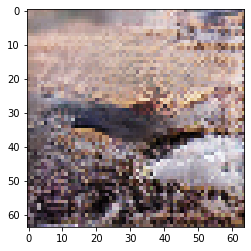

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 36

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.092921018600464 sec
Gen loss: 3.546596630478939, Disc loss: 0.60104783424517
Time for epoch 2 is 13.09351634979248 sec
Gen loss: 3.5720155917532077, Disc loss: 0.596340152871641
Time for epoch 3 is 13.06959342956543 sec
Gen loss: 3.582626935266221, Disc loss: 0.5951709614052036
Time for epoch 4 is 13.183380842208862 sec
Gen loss: 3.514392235737829, Disc loss: 0.6029406607474092
Time for epoch 5 is 13.075121641159058 sec
Gen loss: 3.567284266800092, Disc loss: 0.6016873855416368
Time for epoch 6 is 13.07552456855774 sec
Gen loss: 3.5234743327629277, Disc loss: 0.5989111629604971
Time for epoch 7 is 13.097185611724854 sec
Gen loss: 3.5590404837435177, Disc loss: 0.5940457899072952
Time for epoch 8 is 13.102375268936157 sec
Gen loss: 3.6049518462442123, Disc loss: 0.5931426277005576
Time for epoch 9 is 13.055968284606934 sec
Gen loss: 3.49260538315708

Time for epoch 80 is 13.068690299987793 sec
Gen loss: 3.5739945040808783, Disc loss: 0.5983302371934823
Time for epoch 81 is 13.066991090774536 sec
Gen loss: 3.5491793091058086, Disc loss: 0.6026242224343101
Time for epoch 82 is 13.07875370979309 sec
Gen loss: 3.5220449862441394, Disc loss: 0.6002462271267806
Time for epoch 83 is 13.12615704536438 sec
Gen loss: 3.4998083618598255, Disc loss: 0.6027180928040327
Time for epoch 84 is 13.063848972320557 sec
Gen loss: 3.574231807455461, Disc loss: 0.5920294149296716
Time for epoch 85 is 13.100463151931763 sec
Gen loss: 3.569974824341978, Disc loss: 0.5987467750462736
Time for epoch 86 is 13.115206480026245 sec
Gen loss: 3.550360494189792, Disc loss: 0.5960955158643283
Time for epoch 87 is 13.080239534378052 sec
Gen loss: 3.553624283653611, Disc loss: 0.5946993224504518
Time for epoch 88 is 13.105184078216553 sec
Gen loss: 3.532854497594239, Disc loss: 0.6020358286414366
Time for epoch 89 is 13.071944236755371 sec
Gen loss: 3.612316774482003

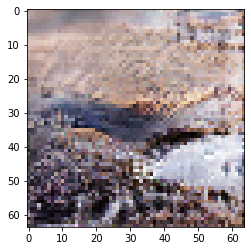

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 37

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.10890507698059 sec
Gen loss: 3.5509399715154797, Disc loss: 0.6003300350532945
Time for epoch 2 is 13.111677408218384 sec
Gen loss: 3.521120786020749, Disc loss: 0.6018442638359742
Time for epoch 3 is 13.080848693847656 sec
Gen loss: 3.5483807322132557, Disc loss: 0.5943357975179264
Time for epoch 4 is 13.094712495803833 sec
Gen loss: 3.6493819942319297, Disc loss: 0.5905465518394459
Time for epoch 5 is 13.138041019439697 sec
Gen loss: 3.5939763303048564, Disc loss: 0.5921563806572581
Time for epoch 6 is 13.081051349639893 sec
Gen loss: 3.531011231223419, Disc loss: 0.5965284090539628
Time for epoch 7 is 13.094354152679443 sec
Gen loss: 3.583747616305261, Disc loss: 0.5944770410616547
Time for epoch 8 is 13.099618196487427 sec
Gen loss: 3.575743872298781, Disc loss: 0.5995658059430317
Time for epoch 9 is 13.081491708755493 sec
Gen loss: 3.527935572

Time for epoch 80 is 13.109692335128784 sec
Gen loss: 3.540989631559791, Disc loss: 0.6016015571145831
Time for epoch 81 is 13.100852966308594 sec
Gen loss: 3.585866365975481, Disc loss: 0.5978663141326852
Time for epoch 82 is 13.08567214012146 sec
Gen loss: 3.530591635200066, Disc loss: 0.599816974262558
Time for epoch 83 is 13.10219955444336 sec
Gen loss: 3.5681324819239175, Disc loss: 0.5927695877506804
Time for epoch 84 is 13.097023248672485 sec
Gen loss: 3.489905855519985, Disc loss: 0.6090599704725632
Time for epoch 85 is 13.097724199295044 sec
Gen loss: 3.5527741411514073, Disc loss: 0.5995950147226897
Time for epoch 86 is 13.102236032485962 sec
Gen loss: 3.5164447018124547, Disc loss: 0.6006931858818706
Time for epoch 87 is 13.130831003189087 sec
Gen loss: 3.4872565579608206, Disc loss: 0.6042368701964536
Time for epoch 88 is 13.105586290359497 sec
Gen loss: 3.6855830228748685, Disc loss: 0.5931074453724755
Time for epoch 89 is 13.089805126190186 sec
Gen loss: 3.485587246695831

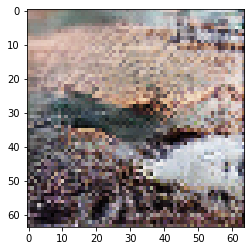

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 38

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.107799768447876 sec
Gen loss: 3.5339449938073715, Disc loss: 0.5981721669677796
Time for epoch 2 is 13.092574834823608 sec
Gen loss: 3.558977223347196, Disc loss: 0.6014258683858525
Time for epoch 3 is 13.094710111618042 sec
Gen loss: 3.4818537997682566, Disc loss: 0.6055582647885733
Time for epoch 4 is 13.167114496231079 sec
Gen loss: 3.5327980654026434, Disc loss: 0.5974067036052383
Time for epoch 5 is 13.098433017730713 sec
Gen loss: 3.507274256166081, Disc loss: 0.6082846172618349
Time for epoch 6 is 13.081425189971924 sec
Gen loss: 3.5502386060833606, Disc loss: 0.5977922693339144
Time for epoch 7 is 13.068828105926514 sec
Gen loss: 3.505858815459378, Disc loss: 0.6025553840770308
Time for epoch 8 is 13.093381881713867 sec
Gen loss: 3.552121372403814, Disc loss: 0.5976901205413063
Time for epoch 9 is 13.081011772155762 sec
Gen loss: 3.56126924

Time for epoch 80 is 13.081815719604492 sec
Gen loss: 3.5430637930789937, Disc loss: 0.6016507745596774
Time for epoch 81 is 13.065706253051758 sec
Gen loss: 3.5254177569050777, Disc loss: 0.6017847276800047
Time for epoch 82 is 13.110113143920898 sec
Gen loss: 3.5394196458625276, Disc loss: 0.601333322886852
Time for epoch 83 is 13.092357635498047 sec
Gen loss: 3.482815513119788, Disc loss: 0.6080706321450107
Time for epoch 84 is 13.07042145729065 sec
Gen loss: 3.512404472847295, Disc loss: 0.6084216765271939
Time for epoch 85 is 13.092865228652954 sec
Gen loss: 3.5114578186334957, Disc loss: 0.6031386857917962
Time for epoch 86 is 13.107790231704712 sec
Gen loss: 3.533694005594021, Disc loss: 0.6023522291564682
Time for epoch 87 is 13.062404870986938 sec
Gen loss: 3.547331394541877, Disc loss: 0.5995621973583045
Time for epoch 88 is 13.171684980392456 sec
Gen loss: 3.524745676252577, Disc loss: 0.5995094589586181
Time for epoch 89 is 13.072264671325684 sec
Gen loss: 3.494209664946972

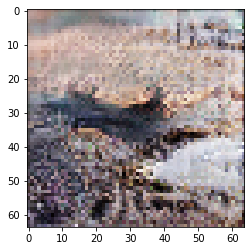

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 39

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 13.09022307395935 sec
Gen loss: 3.5548138792921855, Disc loss: 0.5996656603606413
Time for epoch 2 is 13.115702390670776 sec
Gen loss: 3.5264917020875264, Disc loss: 0.6027379631996155
Time for epoch 3 is 13.09960126876831 sec
Gen loss: 3.5064453607006123, Disc loss: 0.603275802400377
Time for epoch 4 is 13.128136157989502 sec
Gen loss: 3.5637152026985395, Disc loss: 0.6008167434029463
Time for epoch 5 is 13.086631536483765 sec
Gen loss: 3.5382601077640605, Disc loss: 0.6035837623161998
Time for epoch 6 is 13.122052669525146 sec
Gen loss: 3.5644534648595463, Disc loss: 0.5971787013012543
Time for epoch 7 is 13.100330829620361 sec
Gen loss: 3.5438517477454208, Disc loss: 0.6024060106374384
Time for epoch 8 is 13.0905282497406 sec
Gen loss: 3.530564805679528, Disc loss: 0.5994001107648782
Time for epoch 9 is 13.109230041503906 sec
Gen loss: 3.5065892375

Time for epoch 80 is 13.148163557052612 sec
Gen loss: 3.5882307442869275, Disc loss: 0.6009833246550262
Time for epoch 81 is 13.068525791168213 sec
Gen loss: 3.525365203376708, Disc loss: 0.6041929501343549
Time for epoch 82 is 13.088308811187744 sec
Gen loss: 3.512767691599321, Disc loss: 0.6027716998323839
Time for epoch 83 is 13.061276912689209 sec
Gen loss: 3.523928582829835, Disc loss: 0.6041324687844046
Time for epoch 84 is 13.105950593948364 sec
Gen loss: 3.545881136323055, Disc loss: 0.5989953051737653
Time for epoch 85 is 13.108248472213745 sec
Gen loss: 3.544664680796264, Disc loss: 0.6060639558445794
Time for epoch 86 is 13.091468095779419 sec
Gen loss: 3.504995192292583, Disc loss: 0.6033932915547999
Time for epoch 87 is 13.15488052368164 sec
Gen loss: 3.6080259766358993, Disc loss: 0.598971167392524
Time for epoch 88 is 13.120017766952515 sec
Gen loss: 3.5345135995043004, Disc loss: 0.6041821977148857
Time for epoch 89 is 13.11686110496521 sec
Gen loss: 3.518665052041775, 

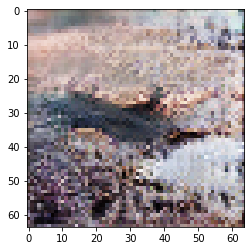

In [70]:
next_starting_checkpoint = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=40, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      d_hist=disc_loss_hist,
                                      noise=noise)

In [ ]:
# noise = np.random.normal(0, 1, 200)

# gen_loss_hist = []
# disc_loss_hist = []

# for i in range(30, 40):
#     gen_temp, disc_temp = train(train_imgs, 100)
#     gen_loss_hist += gen_temp
#     disc_loss_hist += disc_temp
#     generated_image = generator.predict(np.array([noise]))[0]
#     plt.imshow(unnormalize_img(generated_image))
#     plt.savefig('./results/prog-imgs/bird-gan-deeper/' + str((i+1)*100) + '.png')
#     plt.show()
#     generator.save_weights('./results/weights/bird-gan-deeper/gen_weights_deeper_' + str((i+1)*100) + '.h5')
#     discriminator.save_weights('./results/weights/bird-gan-deeper/disc_weights_deeper_' + str((i+1)*100) + '.h5')

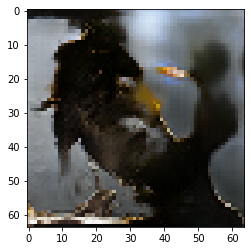

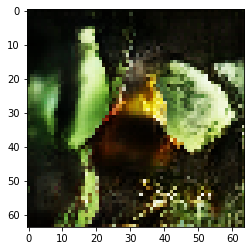

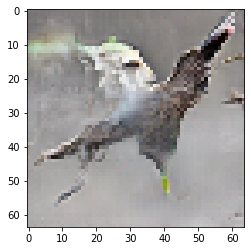

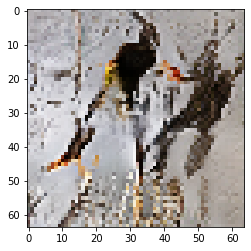

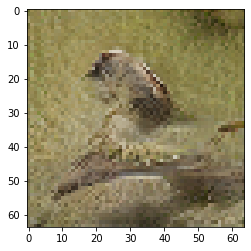

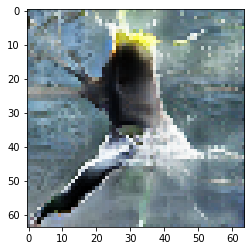

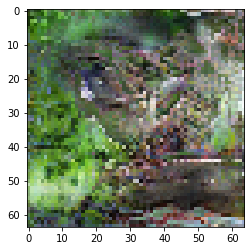

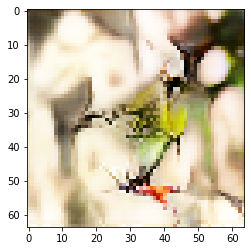

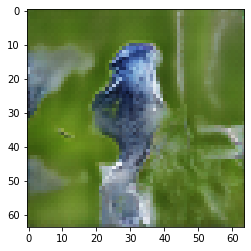

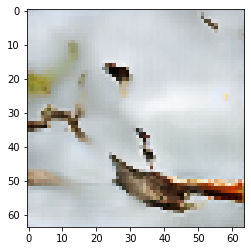

In [80]:
for i in range(10):
    noise = np.random.normal(0, 1, 100)

    generated_image = generator.predict(np.array([noise]))[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()

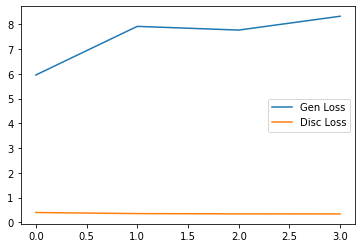

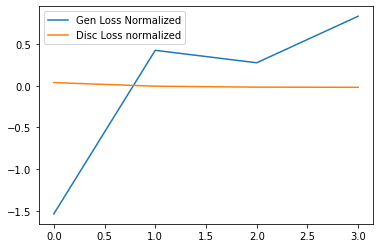

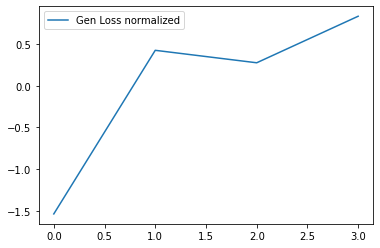

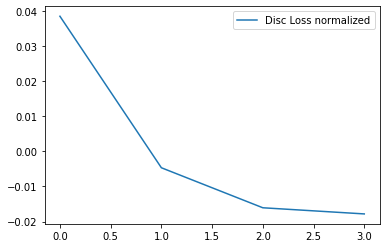

In [61]:
plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.legend(['Gen Loss','Disc Loss'])
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Loss normalized'])
plt.show()

plt.plot(gen_loss_hist - (np.mean(gen_loss_hist)))
plt.legend(['Gen Loss normalized'])
plt.show()

plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Disc Loss normalized'])
plt.show()